# Whisper Model (Large & Small) Evaluation On Stuttering

1. Turn original transcripts into dataframes
2. Read generated transcript dataframes
3. Get Error & Stuttering count
4. Get Error & Stuttering Type ==> show which Stuttering type is more prone to error
5. Calculate Correlation Score
6. Generate Heatmap
7. Summarize Trend

*** 

### Error Metrics
1. Net / Total Word Error Rate
2. Word Error Rate Specific After Cleaning other Stuttering Type Annotations

***

## Using Custom Kernel on SCC

SCC sometimes has the problem with installed library not importable [`module not found` error], this is an alternative.

Assuming you have a conda environment created, you would do the following:
1. `conda install -c anaconda ipykernel` 
2. `python -m ipykernel install --user --name=<env name>`
3. If the new kernel cannot be found, relaunch a new SCC instance

**Remember to switch to the conda env kernel**

In [5]:
ds_transcript_path = "/projectnb/ds549/projects/AImpower/datasets/updated_annotation_deid_full"

In [44]:
!pip install pandas numpy scipy tqdm

---

## Word Error Rate

Objectives:
* split sequence into characters
* count:
    * deletion: missing words
    * substitutions: wrongly recognized words
    * insertions: extra words

In [54]:
def wer(candidate, reference):
    """
    Parameter(s)
    ------------
    candidate ==> generated transcript
    reference ==> dataset transcript
    """
    
    candidate_tokens = list(candidate)
    reference_tokens = list(reference)
    
    cand_len = len(candidate_tokens)
    ref_len = len(reference_tokens)
    
    dist_mat = np.zeros((ref_len, cand_len), dtype=int)
    
    for i in range(ref_len):
        dist_mat[i][0] = i
    for j in range(cand_len):
        dist_mat[0][j] = j
        
    for i in range(1, ref_len):
        for j in range(1, cand_len):
            if (candidate_tokens[j - 1] == reference_tokens[i - 1]):
                cost = 0
            else:
                cost = 1
                
            dist_mat[i][j] = min(
                dist_mat[i-1][j] + 1,
                dist_mat[i][j-1] + 1,
                dist_mat[i-1][j-1] + cost
            )
            # print(dist_mat)
            
    wer = dist_mat[-1][-1] / len(reference_tokens)
    return wer

***

## Imports and Data Ingestion (Whisper Large)

In [66]:
import pandas as pd
import numpy as np
import scipy
import os
from tqdm import tqdm
import re
import sys

In [67]:
net_data = pd.DataFrame(columns=["Filename", "Start_time", "End_time", "Transcript"]) 
net_aigenerated_data_whisper_large = pd.read_csv("/projectnb/ds549/projects/AImpower/datasets/generated-transcripts/Whisper_large.csv", delimiter=",")

del net_aigenerated_data_whisper_large[net_aigenerated_data_whisper_large.columns[0]]

In [68]:
for folder in os.listdir(ds_transcript_path):
    if folder == "command_stats.xlsx" or folder == "command_stats.csv":
        continue
    for audio_sample in os.listdir(os.path.join(ds_transcript_path, f"{folder}")):
        if ("_A.txt" in audio_sample):
            # print("Appending A txt...")
            net_data = pd.concat([net_data, pd.read_csv(os.path.join(ds_transcript_path, f"{folder}/{audio_sample}"), sep="\t", names=["Start_time", "End_time", "Transcript"]).assign(Filename=f"D{folder}_A")])
        if ("_B.txt" in audio_sample):
            # print("Appending B txt...")
            net_data = pd.concat([net_data, pd.read_csv(os.path.join(ds_transcript_path, f"{folder}/{audio_sample}"), sep="\t", names=["Start_time", "End_time", "Transcript"]).assign(Filename=f"D{folder}_B")])
        if ("P" in audio_sample):
            # print("Appending P txt...")
            net_data = pd.concat([net_data, pd.read_csv(os.path.join(ds_transcript_path, f"{folder}/{audio_sample}"), sep="\t", names=["Start_time", "End_time", "Transcript"]).assign(Filename=f"P{folder}")])

/scratch/1364557.1.academic/ipykernel_162605/354492224.py:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  net_data = pd.concat([net_data, pd.read_csv(os.path.join(ds_transcript_path, f"{folder}/{audio_sample}"), sep="\t", names=["Start_time", "End_time", "Transcript"]).assign(Filename=f"D{folder}_A")])


In [69]:
mask_pattern = r"\<.*?\>"
repetition_pattern = r"\[.*?\]"
annotation_pattern = r"/\w"


net_data = net_data.assign(Cleaned_Transcript=net_data['Transcript'].apply(lambda x: re.sub(annotation_pattern, "", re.sub(repetition_pattern, "", re.sub(mask_pattern, "", x)))))
net_data = net_data.assign(Stuttering_Count=net_data['Transcript'].apply(lambda x: len(re.findall(mask_pattern, x)) + len(re.findall(repetition_pattern, x)) + len(re.findall(annotation_pattern, x))))

In [70]:
net_data

,Filename,Start_time,End_time,Transcript,Cleaned_Transcript,Stuttering_Count
0,D0045_A,48.330,58.020,嗯，我[我/b我]现在已经工作了，我是/p一八年毕业的，然后我的专业是/p国际经济与贸易。,嗯，我现在已经工作了，我是一八年毕业的，然后我的专业是国际经济与贸易。,4
1,D0045_A,58.900,72.140,然后我现在嗯/i/p我现在的工作是/p[是]在/p[是在]<人民银行>，但是这个工作就是/p...,然后我现在嗯我现在的工作是在，但是这个工作就是可能快要就不干了。,8
2,D0045_A,74.100,81.260,嗯/i/p然后我平常的爱好是/p比较喜欢看电影，然后还喜欢打网球。,嗯然后我平常的爱好是比较喜欢看电影，然后还喜欢打网球。,3
3,D0045_A,84.930,86.320,嗯/i<overlap>结束了。,嗯结束了。,2
4,D0045_A,100.950,113.700,嗯，这个就是它[它]不是银行系统，然后它然/r后那个之所以不干，是因为就是这个，嗯/i就是现...,嗯，这个就是它不是银行系统，然后它然后那个之所以不干，是因为就是这个，嗯就是现在人民银行的县...,4
...,...,...,...,...,...,...
135,P0030,3202.732,3213.472,单曲循环歌曲最[最最]爱的为何没结果。,单曲循环歌曲最爱的为何没结果。,1
136,P0030,3216.222,3221.042,来[来]一首朴/p树的歌。,来一首朴树的歌。,2
137,P0030,3225.732,3236.142,搜[搜/r/b搜]索小灿的多/p年/p/r/b以后。,搜索小灿的多年以后。,7
138,P0030,3240.652,3253.172,播放半吨/b/r/p孙弟歌孙兄弟的歌。,播放半吨孙弟歌孙兄弟的歌。,3


In [71]:
net_aigenerated_data_whisper_large

,Filename,Start_time,End_time,Whisper_large
0,D0001_A,2081.540000,2109.650000,我说出来就比较的需要时间然后识别的他等你一会儿你那个话还没有说完还没有说出来的话他就取消了也...
1,D0001_A,790.130000,796.580000,第四句有我说的话
2,D0001_A,1562.083518,1586.220000,这部剧评分是不怎么好的因为评论区的那些人都在说男二号好惨的那个就那么情绪但是就一直输给男主角
3,D0001_A,2016.780000,2035.673559,很精准迅飞语音还是迅飞出手来的我记得他是叫迅飞我之前就是他
4,D0001_A,1682.670000,1709.110000,那个是叫什么来的我忘了就是出现了另一个人然后呢他就射了一把箭然后就把那个男二号给绑杀了就是可...
...,...,...,...,...
37248,P0070,2586.616000,2589.346000,三曲循环歌曲这样而已
37249,P0070,2782.496000,2783.706000,杨幂的电影
37250,P0070,2995.296000,2998.116000,你好米亚今天柴油价怎么样
37251,P0070,2604.066000,2606.656000,单曲循环歌曲 琉璃光之歌


***

## Exploration Sector (For validation)

In [72]:
net_data[net_data["Start_time"] == 1201.99]

,Filename,Start_time,End_time,Transcript,Cleaned_Transcript,Stuttering_Count
106,D0022_A,1201.99,1205.47,对对对对对确实[确实]。,对对对对对确实。,1


In [73]:
net_aigenerated_data_whisper_large[net_aigenerated_data_whisper_large["Start_time"] == 1201.99]

,Filename,Start_time,End_time,Whisper_large
2713,D0022_A,1201.99,1205.47,tweet tweet tweet tweet tweet트를 � energized


***

**Now we have raw data of all audio transcriptions from datasets [updated_annotation_deid_full] in `net_data` and AI predicted transcriptions in `net_aigenerated_data_whisper_large`**

***

## Whisper Large WER Analysis

In [74]:
na_count_large = 0
na_count_cleaned = 0
for index, row in tqdm(net_aigenerated_data_whisper_large.iterrows(), total=len(net_aigenerated_data_whisper_large)):
    
    mask_large = (
        (net_aigenerated_data_whisper_large["Filename"] == row["Filename"]) &
        (net_aigenerated_data_whisper_large["Start_time"] == row["Start_time"])
    )

    mask_net = (
        (net_data["Filename"] == row["Filename"]) &
        (net_data["Start_time"] == row["Start_time"])
    )

    
    large_row = net_aigenerated_data_whisper_large.loc[mask_large]
    net_row = net_data.loc[mask_net]

    # print(large_row)
    # print('\n\n\n\n')
    # print(net_row)
    
    if large_row.empty or net_row.empty:
        print("Skipping: One of the rows is empty.")
        continue
        
    whisper_large = large_row["Whisper_large"].values[0]
    cleaned_transcript = net_row["Cleaned_Transcript"].values[0]
    
    if pd.isna(whisper_large) or not isinstance(whisper_large, str):
        print("Skipping due to missing or non-string Whisper_large.")
        na_count_large = na_count_large + 1
        continue
    if pd.isna(cleaned_transcript) or not isinstance(cleaned_transcript, str):
        print("Skipping due to missing or non-string Cleaned_Transcript.")
        na_count_cleaned = na_count_cleaned + 1
        continue

    try:
        
        wer_value = wer(whisper_large, cleaned_transcript)
        
        net_aigenerated_data_whisper_large.loc[mask_large, "WER"] = wer_value
        
        Stuttering_Count = net_row["Stuttering_Count"].values[0]
        net_aigenerated_data_whisper_large.loc[mask_large, "Stuttering_Count"] = Stuttering_Count
        net_aigenerated_data_whisper_large.loc[mask_large, "Stu-wer-compared-groundtruth"] = cleaned_transcript

        # Verify assignment
        # print(f'Assigned Stuttering_Count: {Stuttering_Count}')
        # print(net_aigenerated_data_whisper_large.loc[mask_large, "Stuttering_Count"])

    except Exception as e:
        print(f'ERROR: {e}')
        print('Occurred with the following data:')
        print(large_row)
        print(net_row)
        
net_aigenerated_data_whisper_large = net_aigenerated_data_whisper_large.assign(NA_Count=na_count_large)
net_aigenerated_data_whisper_large = net_aigenerated_data_whisper_large.assign(NA_Cleaned_Count=na_count_cleaned)

  5%|▍         | 1850/37253 [00:12<03:52, 151.99it/s]

Skipping: One of the rows is empty.


 13%|█▎        | 4705/37253 [00:32<03:32, 153.36it/s]

Skipping due to missing or non-string Whisper_large.


 15%|█▌        | 5629/37253 [00:38<03:37, 145.35it/s]

Skipping due to missing or non-string Whisper_large.


 16%|█▌        | 5806/37253 [00:39<03:52, 135.02it/s]

Skipping due to missing or non-string Whisper_large.


 17%|█▋        | 6229/37253 [00:42<03:23, 152.20it/s]

Skipping due to missing or non-string Whisper_large.


 28%|██▊       | 10498/37253 [01:11<03:09, 141.55it/s]

Skipping: One of the rows is empty.


 36%|███▌      | 13332/37253 [01:30<02:41, 148.11it/s]

Skipping due to missing or non-string Whisper_large.


 44%|████▍     | 16507/37253 [01:50<02:00, 171.59it/s]

Skipping due to missing or non-string Whisper_large.


 91%|█████████▏| 34070/37253 [03:32<00:18, 168.53it/s]

Skipping: One of the rows is empty.


 92%|█████████▏| 34104/37253 [03:33<00:18, 168.21it/s]

Skipping: One of the rows is empty.


 93%|█████████▎| 34601/37253 [03:36<00:15, 167.72it/s]

Skipping: One of the rows is empty.


100%|██████████| 37253/37253 [03:51<00:00, 160.82it/s]


In [75]:
net_aigenerated_data_whisper_large

,Filename,Start_time,End_time,Whisper_large,WER,Stuttering_Count,Stu-wer-compared-groundtruth,NA_Count,NA_Cleaned_Count
0,D0001_A,2081.540000,2109.650000,我说出来就比较的需要时间然后识别的他等你一会儿你那个话还没有说完还没有说出来的话他就取消了也...,0.247423,1.0,我说出来就比较的需要时间，哦，然后那个嗯识别的它的就是它等你一会儿，你那个话还没有说完，的还...,6,0
1,D0001_A,790.130000,796.580000,第四句有我说的话,0.500000,1.0,电视剧有，我说的话。,6,0
2,D0001_A,1562.083518,1586.220000,这部剧评分是不怎么好的因为评论区的那些人都在说男二号好惨的那个就那么情绪但是就一直输给男主角,0.312500,10.0,这部剧是不怎么，评分是不怎么好的，呃就因为呃评论区的那些人，他们都在说，呃男二号就好惨的那个...,6,0
3,D0001_A,2016.780000,2035.673559,很精准迅飞语音还是迅飞出手来的我记得他是叫迅飞我之前就是他,0.394737,7.0,很精准，对，呃讯飞语音还是讯飞助手来着，就我记得它是叫讯飞，我之前就是它呃是,6,0
4,D0001_A,1682.670000,1709.110000,那个是叫什么来的我忘了就是出现了另一个人然后呢他就射了一把箭然后就把那个男二号给绑杀了就是可...,0.250000,8.0,一个那个是嗯叫啥来着，我忘了，就是出现了另一个人，然后呢他就射了一把剑，然后就把那个嗯男二号...,6,0
...,...,...,...,...,...,...,...,...,...
37248,P0070,2586.616000,2589.346000,三曲循环歌曲这样而已,0.181818,0.0,单曲循环歌曲这样而已。,6,0
37249,P0070,2782.496000,2783.706000,杨幂的电影,0.166667,0.0,杨幂的电影。,6,0
37250,P0070,2995.296000,2998.116000,你好米亚今天柴油价怎么样,0.266667,0.0,你好，米雅，今天柴油价怎么样。,6,0
37251,P0070,2604.066000,2606.656000,单曲循环歌曲 琉璃光之歌,0.166667,0.0,单曲循环歌曲琉璃光之歌。,6,0


In [76]:
# net_aigenerated_data_whisper_large[net_aigenerated_data_whisper_large["Start_time"] == 878.01]
net_aigenerated_data_whisper_large.isna().sum()

Filename                         0
Start_time                       0
End_time                         0
Whisper_large                    6
WER                             11
Stuttering_Count                11
Stu-wer-compared-groundtruth    11
NA_Count                         0
NA_Cleaned_Count                 0
dtype: int64

In [77]:
net_aigenerated_data_whisper_large.to_csv('net_aigenerated_data_whisper_large_performance_stu.csv', sep=',')

***

## Visualization of Relationship between Stuttering Count and Word Error Rate (Whisper Large)

In [78]:
## Load data from csv if starting here

# net_aigenerated_data_whisper_large = pd.read_csv('/projectnb/ds549/projects/AImpower/evaluation-whisper/net_aigenerated_data_whisper_large_performance_stu.csv', delimiter=',')

In [79]:
import matplotlib.pyplot as plt

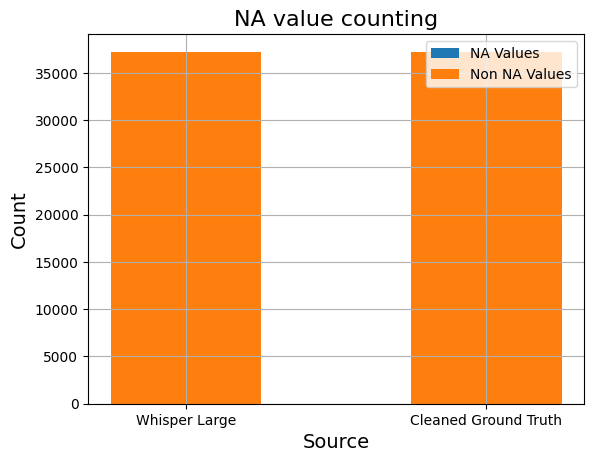

In [80]:
## Null value plots

nonnull_count_large = net_aigenerated_data_whisper_large["NA_Count"].count() - net_aigenerated_data_whisper_large.iloc[0]["NA_Count"]
null_count_large = net_aigenerated_data_whisper_large.iloc[0]["NA_Count"]

nonnull_count_cleaned = net_aigenerated_data_whisper_large["NA_Cleaned_Count"].count() - net_aigenerated_data_whisper_large.iloc[0]["NA_Cleaned_Count"]
null_count_cleaned = net_aigenerated_data_whisper_large.iloc[0]["NA_Cleaned_Count"]


data = {
    "NA Values": [null_count_large, null_count_cleaned],
    "Non NA Values": [nonnull_count_large, nonnull_count_cleaned],
}

species = (
    "Whisper Large",
    "Cleaned Ground Truth"
)

width = 0.5

fig, ax = plt.subplots()
bottom = np.zeros(2)

for na, count in data.items():
    p = ax.bar(species, count, width, label=na, bottom=bottom)
    bottom += count


ax.set_title("NA value counting", fontsize=16)
ax.set_xlabel("Source", fontsize=14)
ax.set_ylabel("Count", fontsize=14)
ax.legend()
ax.grid(True)

plt.show()

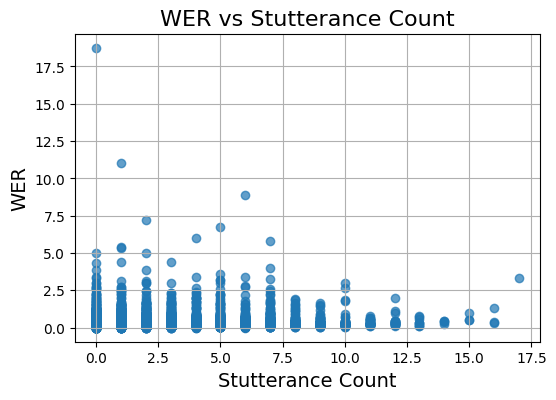

In [81]:
plt.figure(figsize=(6, 4))
plt.scatter(
    net_aigenerated_data_whisper_large["Stuttering_Count"], 
    net_aigenerated_data_whisper_large["WER"], 
    alpha=0.7  # Handle overlapping points
)

plt.title("WER vs Stutterance Count", fontsize=16)
plt.xlabel("Stutterance Count", fontsize=14)
plt.ylabel("WER", fontsize=14)
plt.grid(True)
plt.show()

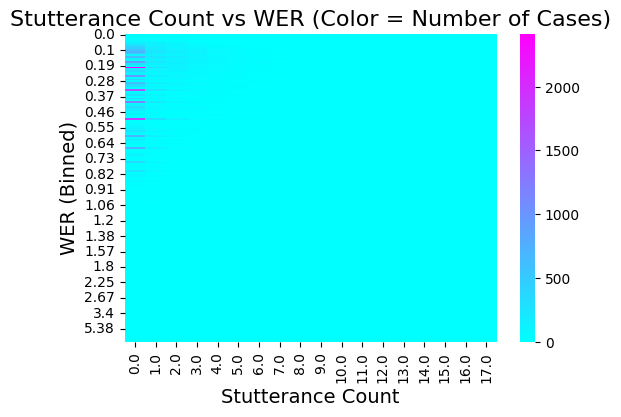

In [82]:
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

net_aigenerated_data_whisper_large['WER_Binned'] = np.round(net_aigenerated_data_whisper_large['WER'], 2)

grouped_data = net_aigenerated_data_whisper_large.groupby(
    ['Stuttering_Count', 'WER_Binned']
).size().reset_index(name='Count')
heatmap_data = grouped_data.pivot(index='WER_Binned', columns='Stuttering_Count', values='Count').fillna(0)

plt.figure(figsize=(6, 4))
sns.heatmap(
    heatmap_data, cmap='cool', annot=False, fmt='g', cbar=True
)

plt.title("Stutterance Count vs WER (Color = Number of Cases)", fontsize=16)
plt.xlabel("Stutterance Count", fontsize=14)
plt.ylabel("WER (Binned)", fontsize=14)

plt.show()

In [83]:
from scipy.stats import spearmanr
rho, p = spearmanr(net_aigenerated_data_whisper_large.dropna()['Stuttering_Count'], net_aigenerated_data_whisper_large.dropna()['WER'])
print(f"p-value = {p}")
print(f"rho = {rho}")

p-value = 5.717674908371687e-196
rho = -0.15383527583445916


***

## ROUGE-N/L Scores (Semantic Evaluation) (Whisper Large)

In [84]:
from rouge_chinese import Rouge
import jieba

In [85]:
rouge = Rouge()

In [86]:
print_ = True

for index, row in tqdm(net_aigenerated_data_whisper_large.iterrows(), total=len(net_aigenerated_data_whisper_large)):
    
    mask_large = (
        (net_aigenerated_data_whisper_large["Filename"] == row["Filename"]) &
        (net_aigenerated_data_whisper_large["Start_time"] == row["Start_time"])
    )

    mask_net = (
        (net_data["Filename"] == row["Filename"]) &
        (net_data["Start_time"] == row["Start_time"])
    )

    
    large_row = net_aigenerated_data_whisper_large.loc[mask_large]
    net_row = net_data.loc[mask_net]

    # print(large_row)
    # print('\n\n\n\n')
    # print(net_row)
    
    if large_row.empty or net_row.empty:
        print("Skipping: One of the rows is empty.")
        continue
        
    whisper_large = large_row["Whisper_large"].values[0]
    cleaned_transcript = net_row["Cleaned_Transcript"].values[0]
    
    if pd.isna(whisper_large) or not isinstance(whisper_large, str):
        print("Skipping due to missing or non-string Whisper_large.")
        continue
    if pd.isna(cleaned_transcript) or not isinstance(cleaned_transcript, str):
        print("Skipping due to missing or non-string Cleaned_Transcript.")
        continue

    try:
        
        scores = rouge.get_scores(' '.join(jieba.cut(whisper_large)), ' '.join(jieba.cut(cleaned_transcript)))
        
        net_aigenerated_data_whisper_large.loc[mask_large, "stu-rouge1-precision"] = scores[0]["rouge-1"]["p"]
        net_aigenerated_data_whisper_large.loc[mask_large, "stu-rouge1-recall"] = scores[0]["rouge-1"]["r"]
        net_aigenerated_data_whisper_large.loc[mask_large, "stu-rouge1-f1"] = scores[0]["rouge-1"]["f"]
        
        
        net_aigenerated_data_whisper_large.loc[mask_large, "stu-rouge2-precision"] = scores[0]["rouge-2"]["p"]
        net_aigenerated_data_whisper_large.loc[mask_large, "stu-rouge2-recall"] = scores[0]["rouge-2"]["r"]
        net_aigenerated_data_whisper_large.loc[mask_large, "stu-rouge2-f1"] = scores[0]["rouge-2"]["f"]
        
        
        net_aigenerated_data_whisper_large.loc[mask_large, "stu-rougel-precision"] = scores[0]["rouge-l"]["p"]
        net_aigenerated_data_whisper_large.loc[mask_large, "stu-rougel-recall"] = scores[0]["rouge-l"]["r"]
        net_aigenerated_data_whisper_large.loc[mask_large, "stu-rougel-f1"] = scores[0]["rouge-l"]["f"]
        
        Stuttering_Count = net_row["Stuttering_Count"].values[0]
        net_aigenerated_data_whisper_large.loc[mask_large, "Stuttering_Count"] = Stuttering_Count
        net_aigenerated_data_whisper_large.loc[mask_large, "Stu-rouge-compared-groundtruth"] = cleaned_transcript

        if (print_):
            print(net_aigenerated_data_whisper_large)
            print_ = False
        
        # Verify assignment
        # print(f'Assigned Stuttering_Count: {Stuttering_Count}')
        # print(net_aigenerated_data_whisper_large.loc[mask_large, "Stuttering_Count"])

    except Exception as e:
        print(f'ERROR: {e}')
        print('Occurred with the following data:')
        print(large_row)
        print(net_row)

  0%|          | 0/37253 [00:00<?, ?it/s]Building prefix dict from the default dictionary ...
Dumping model to file cache /scratch/1364557.1.academic/jieba.cache
Loading model cost 0.598 seconds.
Prefix dict has been built successfully.
  0%|          | 13/37253 [00:00<26:53, 23.08it/s] 

      Filename   Start_time     End_time  \
0      D0001_A  2081.540000  2109.650000   
1      D0001_A   790.130000   796.580000   
2      D0001_A  1562.083518  1586.220000   
3      D0001_A  2016.780000  2035.673559   
4      D0001_A  1682.670000  1709.110000   
...        ...          ...          ...   
37248    P0070  2586.616000  2589.346000   
37249    P0070  2782.496000  2783.706000   
37250    P0070  2995.296000  2998.116000   
37251    P0070  2604.066000  2606.656000   
37252    P0070  2434.606000  2436.576000   

                                           Whisper_large       WER  \
0      我说出来就比较的需要时间然后识别的他等你一会儿你那个话还没有说完还没有说出来的话他就取消了也...  0.247423   
1                                               第四句有我说的话  0.500000   
2         这部剧评分是不怎么好的因为评论区的那些人都在说男二号好惨的那个就那么情绪但是就一直输给男主角  0.312500   
3                          很精准迅飞语音还是迅飞出手来的我记得他是叫迅飞我之前就是他  0.394737   
4      那个是叫什么来的我忘了就是出现了另一个人然后呢他就射了一把箭然后就把那个男二号给绑杀了就是可...  0.250000   
...                                                

  5%|▍         | 1847/37253 [00:15<04:36, 128.03it/s]

Skipping: One of the rows is empty.


 13%|█▎        | 4707/37253 [00:38<04:12, 128.91it/s]

Skipping due to missing or non-string Whisper_large.


 15%|█▌        | 5624/37253 [00:45<04:05, 128.70it/s]

Skipping due to missing or non-string Whisper_large.


 16%|█▌        | 5807/37253 [00:46<04:11, 124.82it/s]

Skipping due to missing or non-string Whisper_large.


 17%|█▋        | 6231/37253 [00:50<03:59, 129.59it/s]

Skipping due to missing or non-string Whisper_large.


 28%|██▊       | 10496/37253 [01:23<03:30, 127.25it/s]

Skipping: One of the rows is empty.


 36%|███▌      | 13331/37253 [01:46<03:05, 128.65it/s]

Skipping due to missing or non-string Whisper_large.


 44%|████▍     | 16494/37253 [02:10<02:37, 131.96it/s]

Skipping due to missing or non-string Whisper_large.


 91%|█████████▏| 34066/37253 [04:24<00:24, 131.51it/s]

Skipping: One of the rows is empty.


 92%|█████████▏| 34108/37253 [04:25<00:23, 131.41it/s]

Skipping: One of the rows is empty.


 93%|█████████▎| 34597/37253 [04:29<00:20, 130.95it/s]

Skipping: One of the rows is empty.


100%|██████████| 37253/37253 [04:49<00:00, 128.77it/s]


In [87]:
net_aigenerated_data_whisper_large

,Filename,Start_time,End_time,Whisper_large,WER,Stuttering_Count,Stu-wer-compared-groundtruth,NA_Count,NA_Cleaned_Count,WER_Binned,stu-rouge1-precision,stu-rouge1-recall,stu-rouge1-f1,stu-rouge2-precision,stu-rouge2-recall,stu-rouge2-f1,stu-rougel-precision,stu-rougel-recall,stu-rougel-f1,Stu-rouge-compared-groundtruth
0,D0001_A,2081.540000,2109.650000,我说出来就比较的需要时间然后识别的他等你一会儿你那个话还没有说完还没有说出来的话他就取消了也...,0.247423,1.0,我说出来就比较的需要时间，哦，然后那个嗯识别的它的就是它等你一会儿，你那个话还没有说完，的还...,6,0,0.25,0.916667,0.868421,0.891892,0.666667,0.524590,0.587156,0.888889,0.685714,0.774194,我说出来就比较的需要时间，哦，然后那个嗯识别的它的就是它等你一会儿，你那个话还没有说完，的还...
1,D0001_A,790.130000,796.580000,第四句有我说的话,0.500000,1.0,电视剧有，我说的话。,6,0,0.50,0.800000,0.571429,0.666667,0.500000,0.333333,0.400000,0.800000,0.571429,0.666667,电视剧有，我说的话。
2,D0001_A,1562.083518,1586.220000,这部剧评分是不怎么好的因为评论区的那些人都在说男二号好惨的那个就那么情绪但是就一直输给男主角,0.312500,10.0,这部剧是不怎么，评分是不怎么好的，呃就因为呃评论区的那些人，他们都在说，呃男二号就好惨的那个...,6,0,0.31,0.880000,0.709677,0.785714,0.555556,0.375000,0.447761,0.857143,0.571429,0.685714,这部剧是不怎么，评分是不怎么好的，呃就因为呃评论区的那些人，他们都在说，呃男二号就好惨的那个...
3,D0001_A,2016.780000,2035.673559,很精准迅飞语音还是迅飞出手来的我记得他是叫迅飞我之前就是他,0.394737,7.0,很精准，对，呃讯飞语音还是讯飞助手来着，就我记得它是叫讯飞，我之前就是它呃是,6,0,0.39,0.733333,0.550000,0.628571,0.333333,0.214286,0.260870,0.631579,0.387097,0.480000,很精准，对，呃讯飞语音还是讯飞助手来着，就我记得它是叫讯飞，我之前就是它呃是
4,D0001_A,1682.670000,1709.110000,那个是叫什么来的我忘了就是出现了另一个人然后呢他就射了一把箭然后就把那个男二号给绑杀了就是可...,0.250000,8.0,一个那个是嗯叫啥来着，我忘了，就是出现了另一个人，然后呢他就射了一把剑，然后就把那个嗯男二号...,6,0,0.25,0.833333,0.757576,0.793651,0.583333,0.477273,0.525000,0.871795,0.693878,0.772727,一个那个是嗯叫啥来着，我忘了，就是出现了另一个人，然后呢他就射了一把剑，然后就把那个嗯男二号...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37248,P0070,2586.616000,2589.346000,三曲循环歌曲这样而已,0.181818,0.0,单曲循环歌曲这样而已。,6,0,0.18,0.800000,0.666667,0.727273,0.750000,0.600000,0.666667,0.800000,0.666667,0.727273,单曲循环歌曲这样而已。
37249,P0070,2782.496000,2783.706000,杨幂的电影,0.166667,0.0,杨幂的电影。,6,0,0.17,1.000000,0.750000,0.857143,1.000000,0.666667,0.800000,1.000000,0.750000,0.857143,杨幂的电影。
37250,P0070,2995.296000,2998.116000,你好米亚今天柴油价怎么样,0.266667,0.0,你好，米雅，今天柴油价怎么样。,6,0,0.27,0.833333,0.625000,0.714286,0.600000,0.375000,0.461538,0.833333,0.555556,0.666667,你好，米雅，今天柴油价怎么样。
37251,P0070,2604.066000,2606.656000,单曲循环歌曲 琉璃光之歌,0.166667,0.0,单曲循环歌曲琉璃光之歌。,6,0,0.17,1.000000,0.833333,0.909091,1.000000,0.800000,0.888889,1.000000,0.833333,0.909091,单曲循环歌曲琉璃光之歌。


In [91]:
# net_aigenerated_data_whisper_large.to_csv('net_aigenerated_data_whisper_large_performance_stu.csv', sep=',')

***

## Visualization of Relationship between Stuttering Count and Rouge Scores (Whisper Large)

In [92]:
## Load data from csv if starting here

# net_aigenerated_data_whisper_large = pd.read_csv('/projectnb/ds549/projects/AImpower/evaluation-whisper/net_aigenerated_data_whisper_large_performance_stu.csv', delimiter=',')

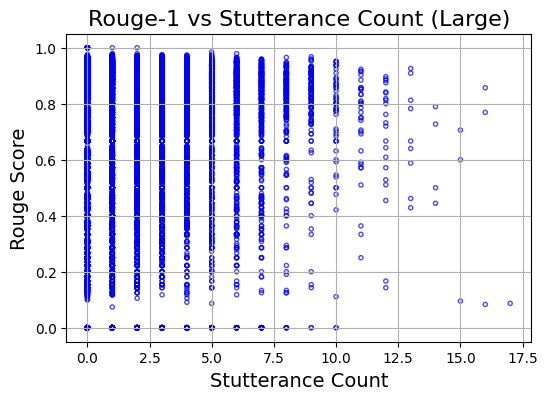

In [94]:
plt.figure(figsize=(6, 4))
# plt.scatter(
#     net_aigenerated_data_whisper_large["Stuttering_Count"], 
#     net_aigenerated_data_whisper_large["rouge1-precision"], 
#     facecolors="none", edgecolors='r',
#     marker="8",
#     alpha=0.7  # Handle overlapping points
# )

# plt.scatter(
#     net_aigenerated_data_whisper_large["Stuttering_Count"], 
#     net_aigenerated_data_whisper_large["rouge1-recall"], 
#     facecolors="none", edgecolors='g',
#     marker="^",
#     alpha=0.7  # Handle overlapping points
# )

plt.scatter(
    net_aigenerated_data_whisper_large["Stuttering_Count"], 
    net_aigenerated_data_whisper_large["stu-rouge1-f1"], 
    facecolors="none", edgecolors='b',
    marker=".",
    alpha=0.7  # Handle overlapping points
)

plt.title("Rouge-1 vs Stutterance Count (Large)", fontsize=16)
plt.xlabel("Stutterance Count", fontsize=14)
plt.ylabel("Rouge Score", fontsize=14)
plt.grid(True)
plt.show()

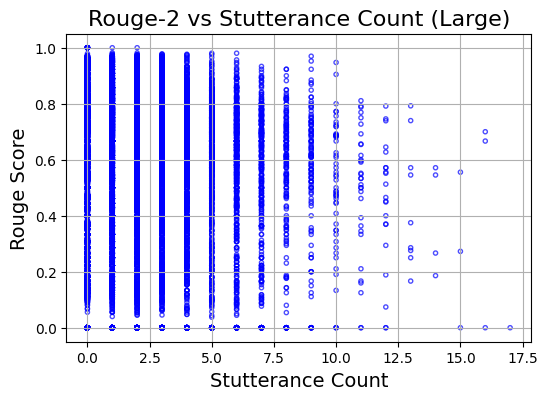

In [95]:
plt.figure(figsize=(6, 4))
# plt.scatter(
#     net_aigenerated_data_whisper_large["Stuttering_Count"], 
#     net_aigenerated_data_whisper_large["rouge2-precision"], 
#     facecolors="none", edgecolors='r',
#     marker="8",
#     alpha=0.7  # Handle overlapping points
# )

# plt.scatter(
#     net_aigenerated_data_whisper_large["Stuttering_Count"], 
#     net_aigenerated_data_whisper_large["rouge2-recall"], 
#     facecolors="none", edgecolors='g',
#     marker="^",
#     alpha=0.7  # Handle overlapping points
# )

plt.scatter(
    net_aigenerated_data_whisper_large["Stuttering_Count"], 
    net_aigenerated_data_whisper_large["stu-rouge2-f1"], 
    facecolors="none", edgecolors='b',
    marker=".",
    alpha=0.7  # Handle overlapping points
)

plt.title("Rouge-2 vs Stutterance Count (Large)", fontsize=16)
plt.xlabel("Stutterance Count", fontsize=14)
plt.ylabel("Rouge Score", fontsize=14)
plt.grid(True)
plt.show()

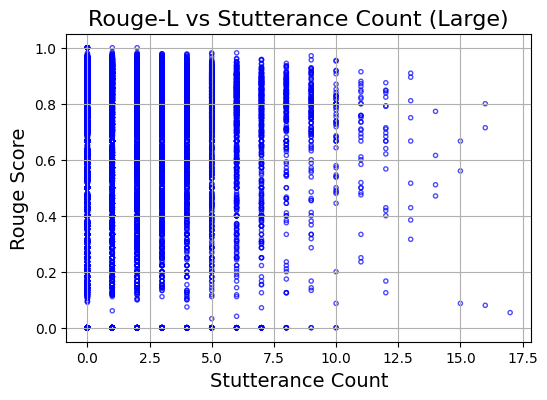

In [96]:
plt.figure(figsize=(6, 4))
# plt.scatter(
#     net_aigenerated_data_whisper_large["Stuttering_Count"], 
#     net_aigenerated_data_whisper_large["rougel-precision"], 
#     facecolors="none", edgecolors='r',
#     marker="8",
#     alpha=0.7  # Handle overlapping points
# )

# plt.scatter(
#     net_aigenerated_data_whisper_large["Stuttering_Count"], 
#     net_aigenerated_data_whisper_large["rougel-recall"], 
#     facecolors="none", edgecolors='g',
#     marker="^",
#     alpha=0.7  # Handle overlapping points
# )

plt.scatter(
    net_aigenerated_data_whisper_large["Stuttering_Count"], 
    net_aigenerated_data_whisper_large["stu-rougel-f1"], 
    facecolors="none", edgecolors='b',
    marker=".",
    alpha=0.7  # Handle overlapping points
)

plt.title("Rouge-L vs Stutterance Count (Large)", fontsize=16)
plt.xlabel("Stutterance Count", fontsize=14)
plt.ylabel("Rouge Score", fontsize=14)
plt.grid(True)
plt.show()

## Correlations between Stuttering and Rouge Scores (Whisper Large)

In [97]:
from scipy.stats import spearmanr

rho, p = spearmanr(net_aigenerated_data_whisper_large.dropna()['Stuttering_Count'], net_aigenerated_data_whisper_large.dropna()['stu-rouge1-f1'])
print(f"p-value [stuttering count & rouge-1 f1] = {p}")
print(f"rho [stuttering count & rouge-1 f1] = {rho}")


rho, p = spearmanr(net_aigenerated_data_whisper_large.dropna()['Stuttering_Count'], net_aigenerated_data_whisper_large.dropna()['stu-rouge2-f1'])
print(f"p-value [stuttering count & rouge-2 f1] = {p}")
print(f"rho [stuttering count & rouge-2 f1] = {rho}")


rho, p = spearmanr(net_aigenerated_data_whisper_large.dropna()['Stuttering_Count'], net_aigenerated_data_whisper_large.dropna()['stu-rougel-f1'])
print(f"p-value [stuttering count & rouge-L f1] = {p}")
print(f"rho [stuttering count & rouge-L f1] = {rho}")

p-value [stuttering count & rouge-1 f1] = 0.0
rho [stuttering count & rouge-1 f1] = 0.27627549733913165
p-value [stuttering count & rouge-2 f1] = 0.0
rho [stuttering count & rouge-2 f1] = 0.22374210928694263
p-value [stuttering count & rouge-L f1] = 0.0
rho [stuttering count & rouge-L f1] = 0.2353466311993851


***
***
***

## Importations and Data Ingestions (Whisper Tiny)

In [103]:
import pandas as pd
import numpy as np
import scipy
import os
from tqdm import tqdm
import re
import sys

In [104]:
net_data = pd.DataFrame(columns=["Filename", "Start_time", "End_time", "Transcript"]) 
net_aigenerated_data_whisper_tiny = pd.read_csv("/projectnb/ds549/projects/AImpower/datasets/generated-transcripts/Whisper_tiny.csv", delimiter=",")

del net_aigenerated_data_whisper_tiny[net_aigenerated_data_whisper_tiny.columns[0]]

In [105]:
for folder in os.listdir(ds_transcript_path):
    if folder == "command_stats.xlsx" or folder == "command_stats.csv":
        continue
    for audio_sample in os.listdir(os.path.join(ds_transcript_path, f"{folder}")):
        if ("_A.txt" in audio_sample):
            net_data = pd.concat([net_data, pd.read_csv(os.path.join(ds_transcript_path, f"{folder}/{audio_sample}"), sep="\t", names=["Start_time", "End_time", "Transcript"]).assign(Filename=f"D{folder}_A")])
        if ("_B.txt" in audio_sample):
            net_data = pd.concat([net_data, pd.read_csv(os.path.join(ds_transcript_path, f"{folder}/{audio_sample}"), sep="\t", names=["Start_time", "End_time", "Transcript"]).assign(Filename=f"D{folder}_B")])
        if ("P" in audio_sample):
            net_data = pd.concat([net_data, pd.read_csv(os.path.join(ds_transcript_path, f"{folder}/{audio_sample}"), sep="\t", names=["Start_time", "End_time", "Transcript"]).assign(Filename=f"P{folder}")])

/scratch/1364557.1.academic/ipykernel_162605/4285821246.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  net_data = pd.concat([net_data, pd.read_csv(os.path.join(ds_transcript_path, f"{folder}/{audio_sample}"), sep="\t", names=["Start_time", "End_time", "Transcript"]).assign(Filename=f"D{folder}_A")])


In [106]:
mask_pattern = r"\<.*?\>"
repetition_pattern = r"\[.*?\]"
annotation_pattern = r"/\w"


net_data = net_data.assign(Cleaned_Transcript=net_data['Transcript'].apply(lambda x: re.sub(annotation_pattern, "", re.sub(repetition_pattern, "", re.sub(mask_pattern, "", x)))))
net_data = net_data.assign(Stuttering_Count=net_data['Transcript'].apply(lambda x: len(re.findall(mask_pattern, x)) + len(re.findall(repetition_pattern, x)) + len(re.findall(annotation_pattern, x))))

In [107]:
net_aigenerated_data_whisper_tiny

,Filename,Start_time,End_time,Whisper_tiny
0,D0001_A,2081.540000,2109.650000,我说出来就比较不需要时间然后那个食别的他的就是他等你一会那个话还没有收完都还没有说出来的话他...
1,D0001_A,790.130000,796.580000,在牙我收到
2,D0001_A,1562.083518,1586.220000,在不计是不怎么平分是不怎么好的就因为平分缺的那些人都在说然后我做好产的那个就那么请问但是就一...
3,D0001_A,2016.780000,2035.673559,很精准的兴非女人还是兴非出手来的就我记得她是叫兴非我之前就是她
4,D0001_A,1682.670000,1709.110000,一个那个是叫抓来的我忘了就是出现了你那个一个人然后他就这了一把剑然后就就把那个拿到给葬撒了就...
...,...,...,...,...
37248,P0070,2586.616000,2589.346000,"單許宣傳歌曲,這樣而已"
37249,P0070,2782.496000,2783.706000,楊秘的電影
37250,P0070,2995.296000,2998.116000,"你好米哈,今天菜油駕怎么样"
37251,P0070,2604.066000,2606.656000,單取新環科曲劉旅光這個


***

## Exploration Sector (For validation)

In [108]:
net_data[net_data["Start_time"] == 1201.99]

,Filename,Start_time,End_time,Transcript,Cleaned_Transcript,Stuttering_Count
106,D0022_A,1201.99,1205.47,对对对对对确实[确实]。,对对对对对确实。,1


In [109]:
net_aigenerated_data_whisper_large[net_aigenerated_data_whisper_large["Start_time"] == 1201.99]

,Filename,Start_time,End_time,Whisper_large,WER,Stuttering_Count,Stu-wer-compared-groundtruth,NA_Count,NA_Cleaned_Count,WER_Binned,stu-rouge1-precision,stu-rouge1-recall,stu-rouge1-f1,stu-rouge2-precision,stu-rouge2-recall,stu-rouge2-f1,stu-rougel-precision,stu-rougel-recall,stu-rougel-f1,Stu-rouge-compared-groundtruth
2713,D0022_A,1201.99,1205.47,tweet tweet tweet tweet tweet트를 � energized,5.375,1.0,对对对对对确实。,6,0,5.38,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,对对对对对确实。


***

**Now we have raw data of all audio transcriptions from datasets [updated_annotation_deid_full] in `net_data` and AI predicted transcriptions in `net_aigenerated_data_whisper_tiny`**

***

## Whisper Tiny WER Analysis

In [110]:
na_count_tiny = 0
na_count_cleaned = 0

for index, row in tqdm(net_aigenerated_data_whisper_tiny.iterrows(), total=len(net_aigenerated_data_whisper_tiny)):
    
    mask_tiny = (
        (net_aigenerated_data_whisper_tiny["Filename"] == row["Filename"]) &
        (net_aigenerated_data_whisper_tiny["Start_time"] == row["Start_time"])
    )

    mask_net = (
        (net_data["Filename"] == row["Filename"]) &
        (net_data["Start_time"] == row["Start_time"])
    )

    
    tiny_row = net_aigenerated_data_whisper_tiny.loc[mask_tiny]
    net_row = net_data.loc[mask_net]

    # print(large_row)
    # print('\n\n\n\n')
    # print(net_row)
    
    if tiny_row.empty or net_row.empty:
        print("Skipping: One of the rows is empty.")
        continue
        
    whisper_tiny = tiny_row["Whisper_tiny"].values[0]
    cleaned_transcript = net_row["Cleaned_Transcript"].values[0]
    
    if pd.isna(whisper_large) or not isinstance(whisper_tiny, str):
        print("Skipping due to missing or non-string Whisper_tiny.")
        na_count_tiny = na_count_tiny + 1
        continue
    if pd.isna(cleaned_transcript) or not isinstance(cleaned_transcript, str):
        print("Skipping due to missing or non-string Cleaned_Transcript.")
        na_count_cleaned = na_count_cleaned + 1
        continue

    try:
        
        wer_value = wer(whisper_tiny, cleaned_transcript)
        
        net_aigenerated_data_whisper_tiny.loc[mask_tiny, "WER"] = wer_value
        
        Stuttering_Count = net_row["Stuttering_Count"].values[0]
        net_aigenerated_data_whisper_tiny.loc[mask_tiny, "Stuttering_Count"] = Stuttering_Count
        net_aigenerated_data_whisper_tiny.loc[mask_tiny, "Stu-wer-compared-groundtruth"] = cleaned_transcript

        # Verify assignment
        # print(f'Assigned Stuttering_Count: {Stuttering_Count}')
        # print(net_aigenerated_data_whisper_large.loc[mask_large, "Stuttering_Count"])

    except Exception as e:
        print(f'ERROR: {e}')
        print('Occurred with the following data:')
        print(large_row)
        print(net_row)
        
net_aigenerated_data_whisper_tiny = net_aigenerated_data_whisper_tiny.assign(NA_Count=na_count_tiny)
net_aigenerated_data_whisper_tiny = net_aigenerated_data_whisper_tiny.assign(NA_Cleaned_Count=na_count_cleaned)

  0%|          | 131/37253 [00:00<04:22, 141.63it/s]

Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.


  0%|          | 179/37253 [00:01<04:06, 150.31it/s]

Skipping due to missing or non-string Whisper_tiny.


  1%|          | 306/37253 [00:02<03:59, 154.41it/s]

Skipping due to missing or non-string Whisper_tiny.


  1%|          | 451/37253 [00:03<04:02, 151.45it/s]

Skipping due to missing or non-string Whisper_tiny.


  1%|▏         | 531/37253 [00:03<03:55, 155.66it/s]

Skipping due to missing or non-string Whisper_tiny.


  2%|▏         | 882/37253 [00:05<04:00, 151.46it/s]

Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.


  3%|▎         | 1183/37253 [00:07<03:37, 165.58it/s]

Skipping due to missing or non-string Whisper_tiny.


  3%|▎         | 1268/37253 [00:08<03:55, 152.99it/s]

Skipping due to missing or non-string Whisper_tiny.


  4%|▎         | 1360/37253 [00:09<04:17, 139.37it/s]

Skipping due to missing or non-string Whisper_tiny.


  4%|▍         | 1507/37253 [00:10<04:11, 142.25it/s]

Skipping due to missing or non-string Whisper_tiny.


  4%|▍         | 1610/37253 [00:10<04:10, 142.16it/s]

Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.


  4%|▍         | 1657/37253 [00:11<03:59, 148.42it/s]

Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.


  5%|▍         | 1705/37253 [00:11<03:50, 154.54it/s]

Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.


  5%|▍         | 1855/37253 [00:12<03:57, 148.80it/s]

Skipping: One of the rows is empty.


  5%|▌         | 1915/37253 [00:12<03:59, 147.31it/s]

Skipping due to missing or non-string Whisper_tiny.


  5%|▌         | 1975/37253 [00:13<04:06, 142.97it/s]

Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.


  5%|▌         | 2021/37253 [00:13<04:08, 141.82it/s]

Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.


  6%|▌         | 2067/37253 [00:13<04:00, 146.12it/s]

Skipping due to missing or non-string Whisper_tiny.


  6%|▌         | 2144/37253 [00:14<03:56, 148.34it/s]

Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.


  6%|▌         | 2208/37253 [00:14<03:51, 151.15it/s]

Skipping due to missing or non-string Whisper_tiny.


  7%|▋         | 2560/37253 [00:17<03:56, 146.62it/s]

Skipping due to missing or non-string Whisper_tiny.


  7%|▋         | 2671/37253 [00:18<03:46, 152.49it/s]

Skipping due to missing or non-string Whisper_tiny.


  7%|▋         | 2703/37253 [00:18<03:44, 153.81it/s]

Skipping due to missing or non-string Whisper_tiny.


  7%|▋         | 2735/37253 [00:18<03:45, 153.02it/s]

Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.


  7%|▋         | 2766/37253 [00:18<04:08, 138.68it/s]

Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.


  8%|▊         | 2809/37253 [00:19<04:15, 134.59it/s]

Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.


  8%|▊         | 2865/37253 [00:19<04:32, 126.31it/s]

Skipping due to missing or non-string Whisper_tiny.


  8%|▊         | 2940/37253 [00:20<04:00, 142.55it/s]

Skipping due to missing or non-string Whisper_tiny.


  9%|▉         | 3360/37253 [00:23<04:31, 124.95it/s]

Skipping due to missing or non-string Whisper_tiny.


  9%|▉         | 3386/37253 [00:23<04:32, 124.20it/s]

Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.


  9%|▉         | 3464/37253 [00:24<04:44, 118.64it/s]

Skipping due to missing or non-string Whisper_tiny.


 10%|▉         | 3716/37253 [00:26<03:36, 154.71it/s]

Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.


 10%|█         | 3767/37253 [00:26<03:28, 160.71it/s]

Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.


 10%|█         | 3801/37253 [00:26<03:32, 157.56it/s]

Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.


 11%|█         | 4049/37253 [00:28<03:24, 162.75it/s]

Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.


 11%|█         | 4083/37253 [00:28<03:30, 157.87it/s]

Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.


 11%|█         | 4132/37253 [00:28<03:24, 161.76it/s]

Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.


 11%|█         | 4183/37253 [00:28<03:25, 160.60it/s]

Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.


 11%|█▏        | 4249/37253 [00:29<03:38, 151.12it/s]

Skipping due to missing or non-string Whisper_tiny.


 12%|█▏        | 4372/37253 [00:30<03:44, 146.79it/s]

Skipping due to missing or non-string Whisper_tiny.


 12%|█▏        | 4456/37253 [00:30<03:23, 160.87it/s]

Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.


 12%|█▏        | 4604/37253 [00:31<03:36, 151.13it/s]

Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.


 13%|█▎        | 4668/37253 [00:32<03:36, 150.25it/s]

Skipping due to missing or non-string Whisper_tiny.


 13%|█▎        | 4701/37253 [00:32<03:34, 151.78it/s]

Skipping due to missing or non-string Whisper_tiny.


 13%|█▎        | 4749/37253 [00:32<03:29, 155.23it/s]

Skipping due to missing or non-string Whisper_tiny.


 13%|█▎        | 4925/37253 [00:33<03:36, 149.37it/s]

Skipping due to missing or non-string Whisper_tiny.


 13%|█▎        | 4973/37253 [00:34<03:31, 152.38it/s]

Skipping due to missing or non-string Whisper_tiny.


 14%|█▎        | 5108/37253 [00:35<03:15, 164.61it/s]

Skipping due to missing or non-string Whisper_tiny.


 14%|█▍        | 5176/37253 [00:35<03:17, 162.52it/s]

Skipping due to missing or non-string Whisper_tiny.


 14%|█▍        | 5335/37253 [00:36<03:34, 149.05it/s]

Skipping due to missing or non-string Whisper_tiny.


 15%|█▌        | 5773/37253 [00:39<04:02, 129.82it/s]

Skipping due to missing or non-string Whisper_tiny.


 16%|█▌        | 5802/37253 [00:39<03:54, 134.13it/s]

Skipping due to missing or non-string Whisper_tiny.


 16%|█▌        | 5832/37253 [00:40<03:42, 141.01it/s]

Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.


 16%|█▌        | 5877/37253 [00:40<03:42, 141.16it/s]

Skipping due to missing or non-string Whisper_tiny.


 16%|█▌        | 5911/37253 [00:40<03:26, 151.64it/s]

Skipping due to missing or non-string Whisper_tiny.


 16%|█▌        | 5962/37253 [00:40<03:16, 158.91it/s]

Skipping due to missing or non-string Whisper_tiny.


 16%|█▌        | 6009/37253 [00:41<03:30, 148.74it/s]

Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.


 16%|█▌        | 6039/37253 [00:41<03:33, 145.89it/s]

Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.


 16%|█▋        | 6084/37253 [00:41<03:38, 142.42it/s]

Skipping due to missing or non-string Whisper_tiny.


 17%|█▋        | 6176/37253 [00:42<03:31, 146.94it/s]

Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.


 17%|█▋        | 6240/37253 [00:42<03:20, 154.81it/s]

Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.


 17%|█▋        | 6275/37253 [00:42<03:13, 159.82it/s]

Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.


 17%|█▋        | 6309/37253 [00:43<03:13, 159.64it/s]

Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.


 18%|█▊        | 6615/37253 [00:45<03:20, 152.85it/s]

Skipping due to missing or non-string Whisper_tiny.


 18%|█▊        | 6663/37253 [00:45<03:19, 153.21it/s]

Skipping due to missing or non-string Whisper_tiny.


 18%|█▊        | 6696/37253 [00:45<03:16, 155.20it/s]

Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.


 18%|█▊        | 6743/37253 [00:46<03:28, 146.43it/s]

Skipping due to missing or non-string Whisper_tiny.


 18%|█▊        | 6804/37253 [00:46<03:27, 146.76it/s]

Skipping due to missing or non-string Whisper_tiny.


 19%|█▉        | 7008/37253 [00:47<03:13, 156.16it/s]

Skipping due to missing or non-string Whisper_tiny.


 19%|█▉        | 7139/37253 [00:48<03:07, 160.45it/s]

Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.


 19%|█▉        | 7173/37253 [00:48<03:04, 162.94it/s]

Skipping due to missing or non-string Whisper_tiny.


 19%|█▉        | 7239/37253 [00:49<03:17, 151.82it/s]

Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.


 20%|██        | 7484/37253 [00:51<03:20, 148.36it/s]

Skipping due to missing or non-string Whisper_tiny.


 20%|██        | 7531/37253 [00:51<03:19, 149.02it/s]

Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.


 20%|██        | 7578/37253 [00:51<03:15, 152.17it/s]

Skipping due to missing or non-string Whisper_tiny.


 21%|██        | 7645/37253 [00:52<03:06, 158.83it/s]

Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.


 21%|██        | 7726/37253 [00:52<03:14, 151.83it/s]

Skipping due to missing or non-string Whisper_tiny.


 21%|██▏       | 7972/37253 [00:54<03:09, 154.42it/s]

Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.


 22%|██▏       | 8085/37253 [00:55<03:08, 154.68it/s]

Skipping due to missing or non-string Whisper_tiny.


 22%|██▏       | 8119/37253 [00:55<03:02, 159.89it/s]

Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.


 22%|██▏       | 8201/37253 [00:55<03:09, 153.26it/s]

Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.


 22%|██▏       | 8233/37253 [00:56<03:07, 154.50it/s]

Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.


 22%|██▏       | 8379/37253 [00:57<03:00, 159.74it/s]

Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.


 23%|██▎       | 8411/37253 [00:57<03:06, 154.75it/s]

Skipping due to missing or non-string Whisper_tiny.


 23%|██▎       | 8529/37253 [00:57<02:57, 162.19it/s]

Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.


 23%|██▎       | 8562/37253 [00:58<03:05, 154.91it/s]

Skipping due to missing or non-string Whisper_tiny.


 23%|██▎       | 8625/37253 [00:58<03:12, 148.35it/s]

Skipping due to missing or non-string Whisper_tiny.


 23%|██▎       | 8688/37253 [00:59<03:13, 147.34it/s]

Skipping due to missing or non-string Whisper_tiny.


 24%|██▎       | 8793/37253 [00:59<03:23, 140.19it/s]

Skipping due to missing or non-string Whisper_tiny.


 24%|██▍       | 9046/37253 [01:01<03:16, 143.37it/s]

Skipping due to missing or non-string Whisper_tiny.


 25%|██▍       | 9140/37253 [01:02<03:04, 152.36it/s]

Skipping due to missing or non-string Whisper_tiny.


 25%|██▍       | 9205/37253 [01:02<03:00, 155.21it/s]

Skipping due to missing or non-string Whisper_tiny.


 25%|██▌       | 9386/37253 [01:03<03:22, 137.47it/s]

Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.


 25%|██▌       | 9447/37253 [01:04<03:15, 142.19it/s]

Skipping due to missing or non-string Whisper_tiny.


 26%|██▌       | 9621/37253 [01:05<03:03, 150.75it/s]

Skipping due to missing or non-string Whisper_tiny.


 26%|██▌       | 9777/37253 [01:06<03:04, 149.26it/s]

Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.


 26%|██▋       | 9809/37253 [01:06<03:02, 150.33it/s]

Skipping due to missing or non-string Whisper_tiny.


 27%|██▋       | 10011/37253 [01:08<03:00, 150.91it/s]

Skipping due to missing or non-string Whisper_tiny.


 27%|██▋       | 10093/37253 [01:08<02:52, 157.55it/s]

Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.


 28%|██▊       | 10321/37253 [01:10<02:50, 158.21it/s]

Skipping due to missing or non-string Whisper_tiny.


 28%|██▊       | 10484/37253 [01:11<03:06, 143.18it/s]

Skipping: One of the rows is empty.


 29%|██▊       | 10623/37253 [01:12<02:57, 150.29it/s]

Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.


 29%|██▊       | 10704/37253 [01:12<02:50, 155.99it/s]

Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.


 29%|██▉       | 10864/37253 [01:13<02:48, 156.36it/s]

Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.


 29%|██▉       | 10913/37253 [01:14<02:49, 155.43it/s]

Skipping due to missing or non-string Whisper_tiny.


 30%|██▉       | 10993/37253 [01:14<02:57, 148.22it/s]

Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.


 30%|███       | 11177/37253 [01:15<02:58, 146.24it/s]

Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.


 30%|███       | 11301/37253 [01:16<02:53, 149.29it/s]

Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.


 31%|███       | 11503/37253 [01:18<02:46, 154.94it/s]

Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.


 31%|███       | 11535/37253 [01:18<02:45, 155.79it/s]

Skipping due to missing or non-string Whisper_tiny.


 31%|███       | 11614/37253 [01:18<02:59, 143.02it/s]

Skipping due to missing or non-string Whisper_tiny.


 31%|███▏      | 11701/37253 [01:19<03:16, 130.08it/s]

Skipping due to missing or non-string Whisper_tiny.


 31%|███▏      | 11730/37253 [01:19<03:07, 136.07it/s]

Skipping due to missing or non-string Whisper_tiny.


 32%|███▏      | 11852/37253 [01:20<02:58, 142.24it/s]

Skipping due to missing or non-string Whisper_tiny.


 32%|███▏      | 11963/37253 [01:21<02:47, 151.04it/s]

Skipping due to missing or non-string Whisper_tiny.


 32%|███▏      | 11996/37253 [01:21<02:48, 150.17it/s]

Skipping due to missing or non-string Whisper_tiny.


 33%|███▎      | 12124/37253 [01:22<02:46, 151.29it/s]

Skipping due to missing or non-string Whisper_tiny.


 33%|███▎      | 12171/37253 [01:22<02:47, 149.66it/s]

Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.


 33%|███▎      | 12220/37253 [01:22<02:42, 153.92it/s]

Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.


 33%|███▎      | 12253/37253 [01:23<02:41, 154.98it/s]

Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.


 33%|███▎      | 12317/37253 [01:23<02:47, 149.06it/s]

Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.


 33%|███▎      | 12462/37253 [01:24<02:36, 158.50it/s]

Skipping due to missing or non-string Whisper_tiny.


 34%|███▎      | 12560/37253 [01:25<02:45, 149.47it/s]

Skipping due to missing or non-string Whisper_tiny.


 34%|███▍      | 12736/37253 [01:26<02:46, 147.44it/s]

Skipping due to missing or non-string Whisper_tiny.


 34%|███▍      | 12782/37253 [01:26<02:46, 146.70it/s]

Skipping due to missing or non-string Whisper_tiny.


 34%|███▍      | 12827/37253 [01:26<02:47, 145.58it/s]

Skipping due to missing or non-string Whisper_tiny.


 35%|███▍      | 12905/37253 [01:27<02:42, 149.63it/s]

Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.


 35%|███▍      | 12965/37253 [01:27<02:49, 143.66it/s]

Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.


 35%|███▌      | 13041/37253 [01:28<02:44, 147.52it/s]

Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.


 35%|███▌      | 13071/37253 [01:28<02:48, 143.68it/s]

Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.


 35%|███▌      | 13116/37253 [01:29<02:52, 139.75it/s]

Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.


 35%|███▌      | 13162/37253 [01:29<02:47, 143.44it/s]

Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.


 35%|███▌      | 13208/37253 [01:29<02:49, 141.99it/s]

Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.


 36%|███▌      | 13255/37253 [01:29<02:40, 149.14it/s]

Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.


 36%|███▌      | 13317/37253 [01:30<02:37, 151.83it/s]

Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.


 36%|███▌      | 13366/37253 [01:30<02:38, 150.86it/s]

Skipping due to missing or non-string Whisper_tiny.


 36%|███▌      | 13412/37253 [01:31<02:41, 147.54it/s]

Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.


 36%|███▌      | 13461/37253 [01:31<02:37, 151.29it/s]

Skipping due to missing or non-string Whisper_tiny.


 36%|███▌      | 13494/37253 [01:31<02:33, 154.51it/s]

Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.


 36%|███▋      | 13561/37253 [01:31<02:28, 159.51it/s]

Skipping due to missing or non-string Whisper_tiny.


 37%|███▋      | 13655/37253 [01:32<02:54, 135.27it/s]

Skipping due to missing or non-string Whisper_tiny.


 37%|███▋      | 13714/37253 [01:33<02:47, 140.65it/s]

Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.


 37%|███▋      | 13760/37253 [01:33<02:41, 145.41it/s]

Skipping due to missing or non-string Whisper_tiny.


 37%|███▋      | 13841/37253 [01:33<02:35, 150.29it/s]

Skipping due to missing or non-string Whisper_tiny.


 37%|███▋      | 13906/37253 [01:34<02:38, 146.93it/s]

Skipping due to missing or non-string Whisper_tiny.


 37%|███▋      | 13966/37253 [01:34<02:47, 139.26it/s]

Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.


 38%|███▊      | 14059/37253 [01:35<02:29, 154.88it/s]

Skipping due to missing or non-string Whisper_tiny.


 38%|███▊      | 14124/37253 [01:35<02:29, 155.22it/s]

Skipping due to missing or non-string Whisper_tiny.


 38%|███▊      | 14253/37253 [01:36<02:31, 151.71it/s]

Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.


 38%|███▊      | 14269/37253 [01:36<02:33, 150.09it/s]

Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.


 38%|███▊      | 14301/37253 [01:36<02:32, 150.28it/s]

Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.


 39%|███▊      | 14349/37253 [01:37<02:35, 147.02it/s]

Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.


 39%|███▊      | 14395/37253 [01:37<02:37, 145.09it/s]

Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.


 39%|███▊      | 14428/37253 [01:37<02:30, 152.15it/s]

Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.


 40%|███▉      | 14746/37253 [01:39<02:23, 156.78it/s]

Skipping due to missing or non-string Whisper_tiny.


 40%|███▉      | 14795/37253 [01:40<02:21, 159.08it/s]

Skipping due to missing or non-string Whisper_tiny.


 40%|███▉      | 14887/37253 [01:40<02:41, 138.71it/s]

Skipping due to missing or non-string Whisper_tiny.


 40%|████      | 14945/37253 [01:41<02:40, 138.90it/s]

Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.


 40%|████      | 14975/37253 [01:41<02:36, 142.58it/s]

Skipping due to missing or non-string Whisper_tiny.


 40%|████      | 15021/37253 [01:41<02:32, 146.05it/s]

Skipping due to missing or non-string Whisper_tiny.


 41%|████      | 15164/37253 [01:42<02:20, 157.67it/s]

Skipping due to missing or non-string Whisper_tiny.


 42%|████▏     | 15593/37253 [01:45<02:09, 167.50it/s]

Skipping due to missing or non-string Whisper_tiny.


 45%|████▌     | 16841/37253 [01:52<02:01, 167.73it/s]

Skipping due to missing or non-string Whisper_tiny.


 47%|████▋     | 17433/37253 [01:56<01:55, 171.95it/s]

Skipping due to missing or non-string Whisper_tiny.


 49%|████▉     | 18369/37253 [02:01<01:51, 169.46it/s]

Skipping due to missing or non-string Whisper_tiny.


 50%|████▉     | 18548/37253 [02:02<01:49, 170.90it/s]

Skipping due to missing or non-string Whisper_tiny.


 52%|█████▏    | 19501/37253 [02:08<01:42, 173.14it/s]

Skipping due to missing or non-string Whisper_tiny.


 58%|█████▊    | 21550/37253 [02:20<01:31, 172.51it/s]

Skipping due to missing or non-string Whisper_tiny.


 62%|██████▏   | 23223/37253 [02:29<01:21, 171.93it/s]

Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.


 63%|██████▎   | 23349/37253 [02:30<01:21, 170.74it/s]

Skipping due to missing or non-string Whisper_tiny.


 63%|██████▎   | 23439/37253 [02:31<01:20, 171.15it/s]

Skipping due to missing or non-string Whisper_tiny.


 63%|██████▎   | 23601/37253 [02:32<01:19, 171.74it/s]

Skipping due to missing or non-string Whisper_tiny.


 65%|██████▌   | 24375/37253 [02:36<01:14, 172.75it/s]

Skipping due to missing or non-string Whisper_tiny.


 66%|██████▋   | 24681/37253 [02:38<01:13, 170.52it/s]

Skipping due to missing or non-string Whisper_tiny.


 66%|██████▋   | 24717/37253 [02:38<01:13, 171.46it/s]

Skipping due to missing or non-string Whisper_tiny.


 67%|██████▋   | 24806/37253 [02:39<01:12, 170.88it/s]

Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.


 67%|██████▋   | 24842/37253 [02:39<01:13, 169.48it/s]

Skipping due to missing or non-string Whisper_tiny.


 67%|██████▋   | 24912/37253 [02:39<01:12, 169.58it/s]

Skipping due to missing or non-string Whisper_tiny.


 67%|██████▋   | 24983/37253 [02:40<01:12, 170.41it/s]

Skipping due to missing or non-string Whisper_tiny.


 67%|██████▋   | 25088/37253 [02:40<01:11, 169.41it/s]

Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.


 70%|███████   | 26138/37253 [02:47<01:05, 168.87it/s]

Skipping due to missing or non-string Whisper_tiny.


 77%|███████▋  | 28812/37253 [03:02<00:49, 170.06it/s]

Skipping due to missing or non-string Whisper_tiny.


 81%|████████  | 30121/37253 [03:10<00:41, 171.37it/s]

Skipping due to missing or non-string Whisper_tiny.


 81%|████████▏ | 30317/37253 [03:11<00:40, 171.18it/s]

Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.


 82%|████████▏ | 30389/37253 [03:11<00:40, 171.33it/s]

Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.


 82%|████████▏ | 30568/37253 [03:13<00:38, 171.92it/s]

Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.


 82%|████████▏ | 30622/37253 [03:13<00:38, 170.30it/s]

Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.


 83%|████████▎ | 30748/37253 [03:14<00:37, 171.55it/s]

Skipping due to missing or non-string Whisper_tiny.


 86%|████████▌ | 31988/37253 [03:21<00:30, 169.99it/s]

Skipping due to missing or non-string Whisper_tiny.


 91%|█████████▏| 34069/37253 [03:33<00:18, 171.39it/s]

Skipping: One of the rows is empty.


 92%|█████████▏| 34105/37253 [03:33<00:18, 171.86it/s]

Skipping: One of the rows is empty.


 93%|█████████▎| 34602/37253 [03:36<00:15, 166.79it/s]

Skipping: One of the rows is empty.


100%|██████████| 37253/37253 [03:52<00:00, 160.26it/s]


In [113]:
net_aigenerated_data_whisper_tiny

,Filename,Start_time,End_time,Whisper_tiny,WER,Stuttering_Count,Stu-wer-compared-groundtruth,NA_Count,NA_Cleaned_Count
0,D0001_A,2081.540000,2109.650000,我说出来就比较不需要时间然后那个食别的他的就是他等你一会那个话还没有收完都还没有说出来的话他...,0.278351,1.0,我说出来就比较的需要时间，哦，然后那个嗯识别的它的就是它等你一会儿，你那个话还没有说完，的还...,332,0
1,D0001_A,790.130000,796.580000,在牙我收到,0.800000,1.0,电视剧有，我说的话。,332,0
2,D0001_A,1562.083518,1586.220000,在不计是不怎么平分是不怎么好的就因为平分缺的那些人都在说然后我做好产的那个就那么请问但是就一...,0.437500,10.0,这部剧是不怎么，评分是不怎么好的，呃就因为呃评论区的那些人，他们都在说，呃男二号就好惨的那个...,332,0
3,D0001_A,2016.780000,2035.673559,很精准的兴非女人还是兴非出手来的就我记得她是叫兴非我之前就是她,0.500000,7.0,很精准，对，呃讯飞语音还是讯飞助手来着，就我记得它是叫讯飞，我之前就是它呃是,332,0
4,D0001_A,1682.670000,1709.110000,一个那个是叫抓来的我忘了就是出现了你那个一个人然后他就这了一把剑然后就就把那个拿到给葬撒了就...,0.367647,8.0,一个那个是嗯叫啥来着，我忘了，就是出现了另一个人，然后呢他就射了一把剑，然后就把那个嗯男二号...,332,0
...,...,...,...,...,...,...,...,...,...
37248,P0070,2586.616000,2589.346000,"單許宣傳歌曲,這樣而已",0.727273,0.0,单曲循环歌曲这样而已。,332,0
37249,P0070,2782.496000,2783.706000,楊秘的電影,0.666667,0.0,杨幂的电影。,332,0
37250,P0070,2995.296000,2998.116000,"你好米哈,今天菜油駕怎么样",0.400000,0.0,你好，米雅，今天柴油价怎么样。,332,0
37251,P0070,2604.066000,2606.656000,單取新環科曲劉旅光這個,0.750000,0.0,单曲循环歌曲琉璃光之歌。,332,0


In [115]:
# net_aigenerated_data_whisper_large.to_csv('net_aigenerated_data_whisper_tiny_performance_stu.csv', sep=',')

***

## Visualization of Relationship between Stuttering Count and Word Error Rate (Whisper Tiny)

In [116]:
## Load data from csv if starting here

# net_aigenerated_data_whisper_tiny = pd.read_csv('/projectnb/ds549/projects/AImpower/evaluation-whisper/net_aigenerated_data_whisper_tiny_performance_stu.csv', delimiter=',')

In [117]:
import matplotlib.pyplot as plt

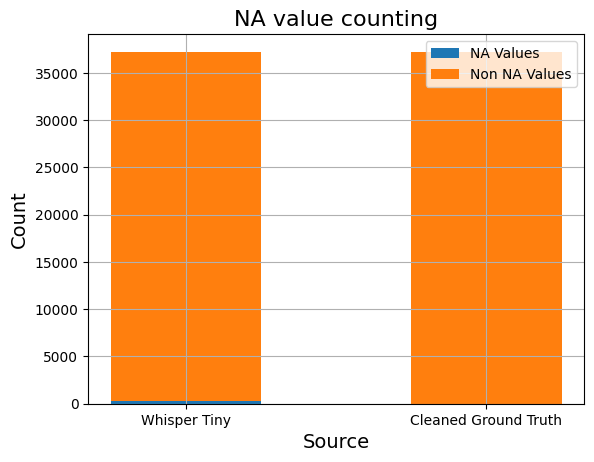

In [118]:
## Null value plots

nonnull_count_tiny = net_aigenerated_data_whisper_tiny["NA_Count"].count() - net_aigenerated_data_whisper_tiny.iloc[0]["NA_Count"]
null_count_tiny = net_aigenerated_data_whisper_tiny.iloc[0]["NA_Count"]

nonnull_count_cleaned = net_aigenerated_data_whisper_tiny["NA_Cleaned_Count"].count() - net_aigenerated_data_whisper_tiny.iloc[0]["NA_Cleaned_Count"]
null_count_cleaned = net_aigenerated_data_whisper_tiny.iloc[0]["NA_Cleaned_Count"]


data = {
    "NA Values": [null_count_tiny, null_count_cleaned],
    "Non NA Values": [nonnull_count_tiny, nonnull_count_cleaned],
}

species = (
    "Whisper Tiny",
    "Cleaned Ground Truth"
)

width = 0.5

fig, ax = plt.subplots()
bottom = np.zeros(2)

for na, count in data.items():
    p = ax.bar(species, count, width, label=na, bottom=bottom)
    bottom += count


ax.set_title("NA value counting", fontsize=16)
ax.set_xlabel("Source", fontsize=14)
ax.set_ylabel("Count", fontsize=14)
ax.legend()
ax.grid(True)

plt.show()

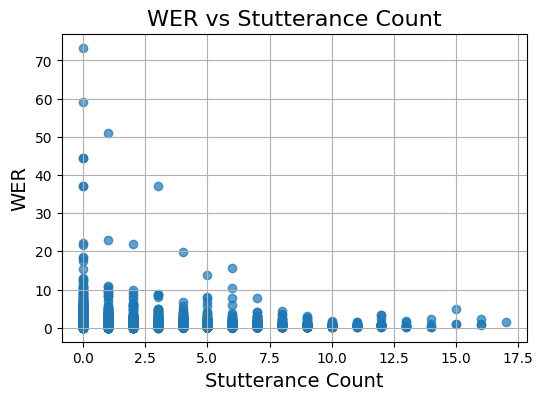

In [119]:
plt.figure(figsize=(6, 4))
plt.scatter(
    net_aigenerated_data_whisper_tiny["Stuttering_Count"], 
    net_aigenerated_data_whisper_tiny["WER"], 
    alpha=0.7  # Handle overlapping points
)

plt.title("WER vs Stutterance Count", fontsize=16)
plt.xlabel("Stutterance Count", fontsize=14)
plt.ylabel("WER", fontsize=14)
plt.grid(True)
plt.show()

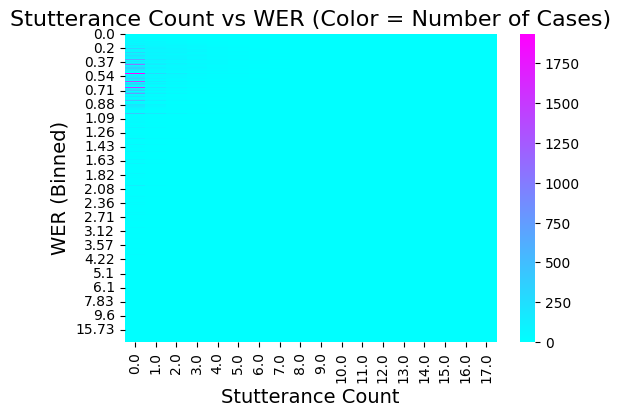

In [120]:
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

net_aigenerated_data_whisper_tiny['WER_Binned'] = np.round(net_aigenerated_data_whisper_tiny['WER'], 2)

grouped_data = net_aigenerated_data_whisper_tiny.groupby(
    ['Stuttering_Count', 'WER_Binned']
).size().reset_index(name='Count')
heatmap_data = grouped_data.pivot(index='WER_Binned', columns='Stuttering_Count', values='Count').fillna(0)

plt.figure(figsize=(6, 4))
sns.heatmap(
    heatmap_data, cmap='cool', annot=False, fmt='g', cbar=True
)

plt.title("Stutterance Count vs WER (Color = Number of Cases)", fontsize=16)
plt.xlabel("Stutterance Count", fontsize=14)
plt.ylabel("WER (Binned)", fontsize=14)

plt.show()

In [121]:
from scipy.stats import spearmanr
rho, p = spearmanr(net_aigenerated_data_whisper_tiny.dropna()['Stuttering_Count'], net_aigenerated_data_whisper_tiny.dropna()['WER'])
print(f"p-value = {p}")
print(f"rho = {rho}")

p-value = 0.0
rho = -0.23094531169290533


***

## ROUGE-N/L Scores (Semantic Evaluation) (Whisper Tiny)

In [122]:
from rouge_chinese import Rouge
import jieba

In [123]:
rouge = Rouge()

In [124]:
print_ = True

for index, row in tqdm(net_aigenerated_data_whisper_tiny.iterrows(), total=len(net_aigenerated_data_whisper_tiny)):
    
    mask_tiny = (
        (net_aigenerated_data_whisper_tiny["Filename"] == row["Filename"]) &
        (net_aigenerated_data_whisper_tiny["Start_time"] == row["Start_time"])
    )

    mask_net = (
        (net_data["Filename"] == row["Filename"]) &
        (net_data["Start_time"] == row["Start_time"])
    )

    
    tiny_row = net_aigenerated_data_whisper_tiny.loc[mask_tiny]
    net_row = net_data.loc[mask_net]

    # print(large_row)
    # print('\n\n\n\n')
    # print(net_row)
    
    if tiny_row.empty or net_row.empty:
        print("Skipping: One of the rows is empty.")
        continue
        
    whisper_tiny = tiny_row["Whisper_tiny"].values[0]
    cleaned_transcript = net_row["Cleaned_Transcript"].values[0]
    
    if pd.isna(whisper_tiny) or not isinstance(whisper_tiny, str):
        print("Skipping due to missing or non-string Whisper_tiny.")
        continue
    if pd.isna(cleaned_transcript) or not isinstance(cleaned_transcript, str):
        print("Skipping due to missing or non-string Cleaned_Transcript.")
        continue

    try:
        
        scores = rouge.get_scores(' '.join(jieba.cut(whisper_tiny)), ' '.join(jieba.cut(cleaned_transcript)))
        
        net_aigenerated_data_whisper_tiny.loc[mask_tiny, "stu-rouge1-precision"] = scores[0]["rouge-1"]["p"]
        net_aigenerated_data_whisper_tiny.loc[mask_tiny, "stu-rouge1-recall"] = scores[0]["rouge-1"]["r"]
        net_aigenerated_data_whisper_tiny.loc[mask_tiny, "stu-rouge1-f1"] = scores[0]["rouge-1"]["f"]
        
        
        net_aigenerated_data_whisper_tiny.loc[mask_tiny, "stu-rouge2-precision"] = scores[0]["rouge-2"]["p"]
        net_aigenerated_data_whisper_tiny.loc[mask_tiny, "stu-rouge2-recall"] = scores[0]["rouge-2"]["r"]
        net_aigenerated_data_whisper_tiny.loc[mask_tiny, "stu-rouge2-f1"] = scores[0]["rouge-2"]["f"]
        
        
        net_aigenerated_data_whisper_tiny.loc[mask_tiny, "stu-rougel-precision"] = scores[0]["rouge-l"]["p"]
        net_aigenerated_data_whisper_tiny.loc[mask_tiny, "stu-rougel-recall"] = scores[0]["rouge-l"]["r"]
        net_aigenerated_data_whisper_tiny.loc[mask_tiny, "stu-rougel-f1"] = scores[0]["rouge-l"]["f"]
        
        Stuttering_Count = net_row["Stuttering_Count"].values[0]
        net_aigenerated_data_whisper_tiny.loc[mask_tiny, "Stuttering_Count"] = Stuttering_Count
        net_aigenerated_data_whisper_tiny.loc[mask_tiny, "Stu-rouge-compared-groundtruth"] = cleaned_transcript

        if (print_):
            print(net_aigenerated_data_whisper_tiny)
            print_ = False
        
        # Verify assignment
        # print(f'Assigned Stuttering_Count: {Stuttering_Count}')
        # print(net_aigenerated_data_whisper_tiny.loc[mask_tiny, "Stuttering_Count"])

    except Exception as e:
        print(f'ERROR: {e}')
        print('Occurred with the following data:')
        print(tiny_row)
        print(net_row)

  0%|          | 22/37253 [00:00<05:37, 110.48it/s]

      Filename   Start_time     End_time  \
0      D0001_A  2081.540000  2109.650000   
1      D0001_A   790.130000   796.580000   
2      D0001_A  1562.083518  1586.220000   
3      D0001_A  2016.780000  2035.673559   
4      D0001_A  1682.670000  1709.110000   
...        ...          ...          ...   
37248    P0070  2586.616000  2589.346000   
37249    P0070  2782.496000  2783.706000   
37250    P0070  2995.296000  2998.116000   
37251    P0070  2604.066000  2606.656000   
37252    P0070  2434.606000  2436.576000   

                                            Whisper_tiny       WER  \
0      我说出来就比较不需要时间然后那个食别的他的就是他等你一会那个话还没有收完都还没有说出来的话他...  0.278351   
1                                                  在牙我收到  0.800000   
2      在不计是不怎么平分是不怎么好的就因为平分缺的那些人都在说然后我做好产的那个就那么请问但是就一...  0.437500   
3                        很精准的兴非女人还是兴非出手来的就我记得她是叫兴非我之前就是她  0.500000   
4      一个那个是叫抓来的我忘了就是出现了你那个一个人然后他就这了一把剑然后就就把那个拿到给葬撒了就...  0.367647   
...                                                

  0%|          | 137/37253 [00:01<04:55, 125.81it/s]

Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.


  0%|          | 177/37253 [00:01<04:48, 128.35it/s]

Skipping due to missing or non-string Whisper_tiny.


  1%|          | 309/37253 [00:02<04:44, 129.86it/s]

Skipping due to missing or non-string Whisper_tiny.


  1%|          | 440/37253 [00:03<04:47, 128.03it/s]

Skipping due to missing or non-string Whisper_tiny.


  1%|▏         | 532/37253 [00:04<04:44, 129.20it/s]

Skipping due to missing or non-string Whisper_tiny.


  2%|▏         | 875/37253 [00:06<04:40, 129.70it/s]

Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.


  3%|▎         | 1179/37253 [00:09<04:35, 130.87it/s]

Skipping due to missing or non-string Whisper_tiny.


  3%|▎         | 1276/37253 [00:10<04:39, 128.88it/s]

Skipping due to missing or non-string Whisper_tiny.


  4%|▎         | 1354/37253 [00:10<04:48, 124.35it/s]

Skipping due to missing or non-string Whisper_tiny.


  4%|▍         | 1497/37253 [00:11<04:41, 126.86it/s]

Skipping due to missing or non-string Whisper_tiny.


  4%|▍         | 1615/37253 [00:12<04:37, 128.38it/s]

Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.


  4%|▍         | 1655/37253 [00:13<04:35, 129.34it/s]

Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.


  5%|▍         | 1683/37253 [00:13<04:31, 130.95it/s]

Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.


  5%|▍         | 1847/37253 [00:14<04:35, 128.42it/s]

Skipping: One of the rows is empty.


  5%|▌         | 1925/37253 [00:15<04:38, 126.77it/s]

Skipping due to missing or non-string Whisper_tiny.


  5%|▌         | 1965/37253 [00:15<04:37, 127.36it/s]

Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.


  5%|▌         | 1991/37253 [00:15<04:39, 125.95it/s]

Skipping due to missing or non-string Whisper_tiny.


  5%|▌         | 2030/37253 [00:15<04:41, 125.16it/s]

Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.


  6%|▌         | 2070/37253 [00:16<04:36, 127.37it/s]

Skipping due to missing or non-string Whisper_tiny.


  6%|▌         | 2136/37253 [00:16<04:33, 128.21it/s]

Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.


  6%|▌         | 2203/37253 [00:17<04:32, 128.74it/s]

Skipping due to missing or non-string Whisper_tiny.


  7%|▋         | 2567/37253 [00:20<04:30, 128.20it/s]

Skipping due to missing or non-string Whisper_tiny.


  7%|▋         | 2659/37253 [00:20<04:30, 128.07it/s]

Skipping due to missing or non-string Whisper_tiny.


  7%|▋         | 2699/37253 [00:21<04:27, 129.19it/s]

Skipping due to missing or non-string Whisper_tiny.


  7%|▋         | 2727/37253 [00:21<04:25, 130.24it/s]

Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.


  7%|▋         | 2780/37253 [00:21<04:32, 126.32it/s]

Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.


  8%|▊         | 2806/37253 [00:22<04:31, 126.81it/s]

Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.


  8%|▊         | 2858/37253 [00:22<04:35, 124.98it/s]

Skipping due to missing or non-string Whisper_tiny.


  8%|▊         | 2936/37253 [00:23<04:31, 126.58it/s]

Skipping due to missing or non-string Whisper_tiny.


  9%|▉         | 3365/37253 [00:26<04:37, 122.32it/s]

Skipping due to missing or non-string Whisper_tiny.


  9%|▉         | 3391/37253 [00:26<04:33, 123.77it/s]

Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.


  9%|▉         | 3456/37253 [00:27<04:36, 122.37it/s]

Skipping due to missing or non-string Whisper_tiny.


 10%|▉         | 3718/37253 [00:29<04:17, 130.39it/s]

Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.


 10%|█         | 3746/37253 [00:29<04:14, 131.49it/s]

Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.


 10%|█         | 3802/37253 [00:30<04:11, 132.81it/s]

Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.


 11%|█         | 4049/37253 [00:31<04:08, 133.60it/s]

Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.


 11%|█         | 4091/37253 [00:32<04:09, 132.67it/s]

Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.


 11%|█         | 4119/37253 [00:32<04:11, 131.81it/s]

Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.


 11%|█         | 4175/37253 [00:32<04:11, 131.59it/s]

Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.


 11%|█▏        | 4243/37253 [00:33<04:18, 127.74it/s]

Skipping due to missing or non-string Whisper_tiny.


 12%|█▏        | 4374/37253 [00:34<04:15, 128.60it/s]

Skipping due to missing or non-string Whisper_tiny.


 12%|█▏        | 4457/37253 [00:35<04:07, 132.33it/s]

Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.


 12%|█▏        | 4604/37253 [00:36<04:13, 128.95it/s]

Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.


 13%|█▎        | 4670/37253 [00:36<04:12, 128.86it/s]

Skipping due to missing or non-string Whisper_tiny.


 13%|█▎        | 4697/37253 [00:36<04:11, 129.35it/s]

Skipping due to missing or non-string Whisper_tiny.


 13%|█▎        | 4750/37253 [00:37<04:10, 129.76it/s]

Skipping due to missing or non-string Whisper_tiny.


 13%|█▎        | 4921/37253 [00:38<04:14, 126.88it/s]

Skipping due to missing or non-string Whisper_tiny.


 13%|█▎        | 4961/37253 [00:39<04:11, 128.44it/s]

Skipping due to missing or non-string Whisper_tiny.


 14%|█▎        | 5096/37253 [00:40<04:05, 130.89it/s]

Skipping due to missing or non-string Whisper_tiny.


 14%|█▍        | 5166/37253 [00:40<04:04, 131.27it/s]

Skipping due to missing or non-string Whisper_tiny.


 14%|█▍        | 5337/37253 [00:41<04:09, 128.08it/s]

Skipping due to missing or non-string Whisper_tiny.


 16%|█▌        | 5780/37253 [00:45<04:13, 124.30it/s]

Skipping due to missing or non-string Whisper_tiny.


 16%|█▌        | 5806/37253 [00:45<04:11, 125.07it/s]

Skipping due to missing or non-string Whisper_tiny.


 16%|█▌        | 5833/37253 [00:45<04:07, 127.00it/s]

Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.


 16%|█▌        | 5872/37253 [00:46<04:09, 125.86it/s]

Skipping due to missing or non-string Whisper_tiny.


 16%|█▌        | 5913/37253 [00:46<04:02, 129.23it/s]

Skipping due to missing or non-string Whisper_tiny.


 16%|█▌        | 5968/37253 [00:46<03:59, 130.71it/s]

Skipping due to missing or non-string Whisper_tiny.


 16%|█▌        | 5996/37253 [00:47<04:00, 130.06it/s]

Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.


 16%|█▌        | 6037/37253 [00:47<04:01, 129.36it/s]

Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.


 16%|█▋        | 6089/37253 [00:47<04:02, 128.26it/s]

Skipping due to missing or non-string Whisper_tiny.


 17%|█▋        | 6168/37253 [00:48<04:04, 126.95it/s]

Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.


 17%|█▋        | 6236/37253 [00:49<03:55, 131.47it/s]

Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.


 17%|█▋        | 6264/37253 [00:49<03:52, 133.44it/s]

Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.


 17%|█▋        | 6292/37253 [00:49<03:48, 135.78it/s]

Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.


 18%|█▊        | 6611/37253 [00:51<03:57, 128.90it/s]

Skipping due to missing or non-string Whisper_tiny.


 18%|█▊        | 6651/37253 [00:52<03:57, 129.06it/s]

Skipping due to missing or non-string Whisper_tiny.


 18%|█▊        | 6692/37253 [00:52<03:54, 130.20it/s]

Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.


 18%|█▊        | 6732/37253 [00:52<03:56, 128.86it/s]

Skipping due to missing or non-string Whisper_tiny.


 18%|█▊        | 6798/37253 [00:53<03:57, 128.33it/s]

Skipping due to missing or non-string Whisper_tiny.


 19%|█▉        | 6995/37253 [00:54<03:52, 130.06it/s]

Skipping due to missing or non-string Whisper_tiny.


 19%|█▉        | 7131/37253 [00:56<03:55, 128.17it/s]

Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.


 19%|█▉        | 7171/37253 [00:56<03:54, 128.33it/s]

Skipping due to missing or non-string Whisper_tiny.


 19%|█▉        | 7237/37253 [00:56<03:55, 127.37it/s]

Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.


 20%|██        | 7471/37253 [00:58<03:56, 125.89it/s]

Skipping due to missing or non-string Whisper_tiny.


 20%|██        | 7538/37253 [00:59<03:49, 129.47it/s]

Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.


 20%|██        | 7565/37253 [00:59<03:49, 129.47it/s]

Skipping due to missing or non-string Whisper_tiny.


 20%|██        | 7634/37253 [00:59<03:45, 131.24it/s]

Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.


 21%|██        | 7718/37253 [01:00<03:47, 129.70it/s]

Skipping due to missing or non-string Whisper_tiny.


 21%|██▏       | 7969/37253 [01:02<03:44, 130.60it/s]

Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.


 22%|██▏       | 8075/37253 [01:03<03:47, 128.42it/s]

Skipping due to missing or non-string Whisper_tiny.


 22%|██▏       | 8114/37253 [01:03<03:48, 127.34it/s]

Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.


 22%|██▏       | 8207/37253 [01:04<03:44, 129.66it/s]

Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.


 22%|██▏       | 8235/37253 [01:04<03:43, 130.03it/s]

Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.


 22%|██▏       | 8370/37253 [01:05<03:41, 130.65it/s]

Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.


 23%|██▎       | 8398/37253 [01:05<03:39, 131.35it/s]

Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.


 23%|██▎       | 8521/37253 [01:06<03:39, 130.84it/s]

Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.


 23%|██▎       | 8563/37253 [01:07<03:41, 129.68it/s]

Skipping due to missing or non-string Whisper_tiny.


 23%|██▎       | 8628/37253 [01:07<03:42, 128.60it/s]

Skipping due to missing or non-string Whisper_tiny.


 23%|██▎       | 8694/37253 [01:08<03:41, 128.81it/s]

Skipping due to missing or non-string Whisper_tiny.


 24%|██▎       | 8785/37253 [01:08<03:46, 125.44it/s]

Skipping due to missing or non-string Whisper_tiny.


 24%|██▍       | 9032/37253 [01:10<03:42, 126.92it/s]

Skipping due to missing or non-string Whisper_tiny.


 25%|██▍       | 9137/37253 [01:11<03:39, 128.12it/s]

Skipping due to missing or non-string Whisper_tiny.


 25%|██▍       | 9203/37253 [01:12<03:38, 128.60it/s]

Skipping due to missing or non-string Whisper_tiny.


 25%|██▌       | 9372/37253 [01:13<03:47, 122.50it/s]

Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.


 25%|██▌       | 9437/37253 [01:14<03:48, 121.71it/s]

Skipping due to missing or non-string Whisper_tiny.


 26%|██▌       | 9619/37253 [01:15<03:43, 123.68it/s]

Skipping due to missing or non-string Whisper_tiny.


 26%|██▌       | 9762/37253 [01:16<03:39, 125.07it/s]

Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.


 26%|██▋       | 9814/37253 [01:17<03:38, 125.49it/s]

Skipping due to missing or non-string Whisper_tiny.


 27%|██▋       | 10009/37253 [01:18<03:37, 125.27it/s]

Skipping due to missing or non-string Whisper_tiny.


 27%|██▋       | 10088/37253 [01:19<03:32, 127.88it/s]

Skipping due to missing or non-string Whisper_tiny.


 27%|██▋       | 10115/37253 [01:19<03:31, 128.41it/s]

Skipping due to missing or non-string Whisper_tiny.


 28%|██▊       | 10311/37253 [01:21<03:30, 128.23it/s]

Skipping due to missing or non-string Whisper_tiny.


 28%|██▊       | 10494/37253 [01:22<03:33, 125.22it/s]

Skipping: One of the rows is empty.


 28%|██▊       | 10611/37253 [01:23<03:29, 127.39it/s]

Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.


 29%|██▊       | 10705/37253 [01:24<03:23, 130.68it/s]

Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.


 29%|██▉       | 10864/37253 [01:25<03:22, 130.36it/s]

Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.


 29%|██▉       | 10906/37253 [01:25<03:22, 130.26it/s]

Skipping due to missing or non-string Whisper_tiny.


 29%|██▉       | 10985/37253 [01:26<03:27, 126.64it/s]

Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.


 30%|██▉       | 11167/37253 [01:27<03:30, 123.87it/s]

Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.


 30%|███       | 11297/37253 [01:28<03:30, 123.41it/s]

Skipping due to missing or non-string Whisper_tiny.


 30%|███       | 11323/37253 [01:29<03:27, 125.07it/s]

Skipping due to missing or non-string Whisper_tiny.


 31%|███       | 11507/37253 [01:30<03:17, 130.47it/s]

Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.


 31%|███       | 11535/37253 [01:30<03:17, 130.11it/s]

Skipping due to missing or non-string Whisper_tiny.


 31%|███       | 11615/37253 [01:31<03:24, 125.49it/s]

Skipping due to missing or non-string Whisper_tiny.


 31%|███▏      | 11706/37253 [01:32<03:24, 124.68it/s]

Skipping due to missing or non-string Whisper_tiny.


 31%|███▏      | 11732/37253 [01:32<03:22, 126.14it/s]

Skipping due to missing or non-string Whisper_tiny.


 32%|███▏      | 11850/37253 [01:33<03:19, 127.10it/s]

Skipping due to missing or non-string Whisper_tiny.


 32%|███▏      | 11954/37253 [01:34<03:17, 127.95it/s]

Skipping due to missing or non-string Whisper_tiny.


 32%|███▏      | 11994/37253 [01:34<03:16, 128.76it/s]

Skipping due to missing or non-string Whisper_tiny.


 33%|███▎      | 12115/37253 [01:35<03:14, 129.14it/s]

Skipping due to missing or non-string Whisper_tiny.


 33%|███▎      | 12156/37253 [01:35<03:13, 129.62it/s]

Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.


 33%|███▎      | 12212/37253 [01:36<03:14, 128.44it/s]

Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.


 33%|███▎      | 12251/37253 [01:36<03:19, 125.55it/s]

Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.


 33%|███▎      | 12317/37253 [01:36<03:14, 128.25it/s]

Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.


 33%|███▎      | 12464/37253 [01:38<03:09, 130.67it/s]

Skipping due to missing or non-string Whisper_tiny.


 34%|███▎      | 12558/37253 [01:38<03:12, 128.47it/s]

Skipping due to missing or non-string Whisper_tiny.


 34%|███▍      | 12728/37253 [01:40<03:10, 128.60it/s]

Skipping due to missing or non-string Whisper_tiny.


 34%|███▍      | 12780/37253 [01:40<03:10, 128.29it/s]

Skipping due to missing or non-string Whisper_tiny.


 34%|███▍      | 12820/37253 [01:40<03:10, 127.97it/s]

Skipping due to missing or non-string Whisper_tiny.


 35%|███▍      | 12900/37253 [01:41<03:09, 128.70it/s]

Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.


 35%|███▍      | 12928/37253 [01:41<03:07, 129.61it/s]

Skipping due to missing or non-string Whisper_tiny.


 35%|███▍      | 12969/37253 [01:42<03:07, 129.81it/s]

Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.


 35%|███▍      | 13036/37253 [01:42<03:05, 130.82it/s]

Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.


 35%|███▌      | 13077/37253 [01:42<03:07, 129.09it/s]

Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.


 35%|███▌      | 13103/37253 [01:43<03:08, 128.09it/s]

Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.


 35%|███▌      | 13157/37253 [01:43<03:05, 129.72it/s]

Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.


 35%|███▌      | 13185/37253 [01:43<03:07, 128.53it/s]

Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.


 36%|███▌      | 13238/37253 [01:44<03:07, 127.75it/s]

Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.


 36%|███▌      | 13266/37253 [01:44<03:04, 130.23it/s]

Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.


 36%|███▌      | 13321/37253 [01:44<03:03, 130.07it/s]

Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.


 36%|███▌      | 13363/37253 [01:45<03:04, 129.66it/s]

Skipping due to missing or non-string Whisper_tiny.


 36%|███▌      | 13416/37253 [01:45<03:04, 129.06it/s]

Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.


 36%|███▌      | 13458/37253 [01:45<03:03, 129.37it/s]

Skipping due to missing or non-string Whisper_tiny.


 36%|███▌      | 13499/37253 [01:46<03:00, 131.49it/s]

Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.


 36%|███▋      | 13555/37253 [01:46<03:03, 129.07it/s]

Skipping due to missing or non-string Whisper_tiny.


 37%|███▋      | 13647/37253 [01:47<03:07, 126.06it/s]

Skipping due to missing or non-string Whisper_tiny.


 37%|███▋      | 13713/37253 [01:47<03:02, 128.71it/s]

Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.


 37%|███▋      | 13767/37253 [01:48<03:01, 129.09it/s]

Skipping due to missing or non-string Whisper_tiny.


 37%|███▋      | 13848/37253 [01:48<03:00, 129.82it/s]

Skipping due to missing or non-string Whisper_tiny.


 37%|███▋      | 13913/37253 [01:49<03:03, 127.29it/s]

Skipping due to missing or non-string Whisper_tiny.


 37%|███▋      | 13966/37253 [01:49<03:01, 128.23it/s]

Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.


 38%|███▊      | 14047/37253 [01:50<02:57, 130.45it/s]

Skipping due to missing or non-string Whisper_tiny.


 38%|███▊      | 14131/37253 [01:51<02:57, 130.49it/s]

Skipping due to missing or non-string Whisper_tiny.


 38%|███▊      | 14238/37253 [01:51<02:57, 129.82it/s]

Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.


 38%|███▊      | 14277/37253 [01:52<02:59, 128.18it/s]

Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.


 38%|███▊      | 14305/37253 [01:52<02:54, 131.76it/s]

Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.


 39%|███▊      | 14347/37253 [01:52<02:54, 131.15it/s]

Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.


 39%|███▊      | 14375/37253 [01:52<02:52, 132.64it/s]

Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.


 39%|███▊      | 14403/37253 [01:53<02:53, 131.37it/s]

Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.


 39%|███▊      | 14431/37253 [01:53<02:50, 134.05it/s]

Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.


 40%|███▉      | 14737/37253 [01:55<02:53, 129.71it/s]

Skipping due to missing or non-string Whisper_tiny.


 40%|███▉      | 14778/37253 [01:56<02:52, 130.65it/s]

Skipping due to missing or non-string Whisper_tiny.


 40%|███▉      | 14885/37253 [01:56<02:58, 125.59it/s]

Skipping due to missing or non-string Whisper_tiny.


 40%|████      | 14937/37253 [01:57<02:55, 127.40it/s]

Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.


 40%|████      | 14964/37253 [01:57<02:52, 128.96it/s]

Skipping due to missing or non-string Whisper_tiny.


 40%|████      | 15017/37253 [01:57<02:53, 128.47it/s]

Skipping due to missing or non-string Whisper_tiny.


 41%|████      | 15150/37253 [01:58<02:50, 129.69it/s]

Skipping due to missing or non-string Whisper_tiny.


 42%|████▏     | 15597/37253 [02:02<02:43, 132.43it/s]

Skipping due to missing or non-string Whisper_tiny.


 45%|████▌     | 16842/37253 [02:11<02:35, 131.25it/s]

Skipping due to missing or non-string Whisper_tiny.


 47%|████▋     | 17430/37253 [02:16<02:30, 131.33it/s]

Skipping due to missing or non-string Whisper_tiny.


 49%|████▉     | 18354/37253 [02:23<02:22, 132.77it/s]

Skipping due to missing or non-string Whisper_tiny.


 50%|████▉     | 18536/37253 [02:24<02:22, 131.80it/s]

Skipping due to missing or non-string Whisper_tiny.


 52%|█████▏    | 19501/37253 [02:32<02:14, 131.73it/s]

Skipping due to missing or non-string Whisper_tiny.


 58%|█████▊    | 21556/37253 [02:47<01:58, 132.11it/s]

Skipping due to missing or non-string Whisper_tiny.


 62%|██████▏   | 23216/37253 [03:00<01:45, 133.19it/s]

Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.


 63%|██████▎   | 23356/37253 [03:01<01:44, 132.81it/s]

Skipping due to missing or non-string Whisper_tiny.


 63%|██████▎   | 23440/37253 [03:02<01:44, 131.95it/s]

Skipping due to missing or non-string Whisper_tiny.


 63%|██████▎   | 23608/37253 [03:03<01:42, 133.07it/s]

Skipping due to missing or non-string Whisper_tiny.


 65%|██████▌   | 24377/37253 [03:09<01:36, 133.25it/s]

Skipping due to missing or non-string Whisper_tiny.


 66%|██████▌   | 24671/37253 [03:11<01:35, 132.02it/s]

Skipping due to missing or non-string Whisper_tiny.


 66%|██████▋   | 24713/37253 [03:11<01:36, 130.56it/s]

Skipping due to missing or non-string Whisper_tiny.


 67%|██████▋   | 24797/37253 [03:12<01:34, 131.55it/s]

Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.


 67%|██████▋   | 24839/37253 [03:12<01:34, 131.74it/s]

Skipping due to missing or non-string Whisper_tiny.


 67%|██████▋   | 24895/37253 [03:13<01:34, 131.44it/s]

Skipping due to missing or non-string Whisper_tiny.


 67%|██████▋   | 24979/37253 [03:13<01:32, 132.23it/s]

Skipping due to missing or non-string Whisper_tiny.


 67%|██████▋   | 25077/37253 [03:14<01:32, 131.76it/s]

Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.


 70%|███████   | 26129/37253 [03:22<01:26, 129.28it/s]

Skipping due to missing or non-string Whisper_tiny.


 77%|███████▋  | 28807/37253 [03:43<01:03, 132.01it/s]

Skipping due to missing or non-string Whisper_tiny.


 81%|████████  | 30119/37253 [03:53<00:54, 132.10it/s]

Skipping due to missing or non-string Whisper_tiny.


 81%|████████▏ | 30301/37253 [03:54<00:52, 132.39it/s]

Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.


 82%|████████▏ | 30385/37253 [03:55<00:52, 131.22it/s]

Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.


 82%|████████▏ | 30567/37253 [03:56<00:49, 134.43it/s]

Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.


 82%|████████▏ | 30609/37253 [03:56<00:49, 133.37it/s]

Skipping due to missing or non-string Whisper_tiny.
Skipping due to missing or non-string Whisper_tiny.


 83%|████████▎ | 30749/37253 [03:57<00:49, 131.70it/s]

Skipping due to missing or non-string Whisper_tiny.


 86%|████████▌ | 31980/37253 [04:07<00:40, 131.22it/s]

Skipping due to missing or non-string Whisper_tiny.


 91%|█████████▏| 34070/37253 [04:23<00:24, 132.00it/s]

Skipping: One of the rows is empty.


 92%|█████████▏| 34098/37253 [04:23<00:23, 132.28it/s]

Skipping: One of the rows is empty.


 93%|█████████▎| 34588/37253 [04:27<00:20, 130.10it/s]

Skipping: One of the rows is empty.


100%|██████████| 37253/37253 [04:47<00:00, 129.55it/s]


In [125]:
net_aigenerated_data_whisper_tiny

,Filename,Start_time,End_time,Whisper_tiny,WER,Stuttering_Count,Stu-wer-compared-groundtruth,NA_Count,NA_Cleaned_Count,WER_Binned,stu-rouge1-precision,stu-rouge1-recall,stu-rouge1-f1,stu-rouge2-precision,stu-rouge2-recall,stu-rouge2-f1,stu-rougel-precision,stu-rougel-recall,stu-rougel-f1,Stu-rouge-compared-groundtruth
0,D0001_A,2081.540000,2109.650000,我说出来就比较不需要时间然后那个食别的他的就是他等你一会那个话还没有收完都还没有说出来的话他...,0.278351,1.0,我说出来就比较的需要时间，哦，然后那个嗯识别的它的就是它等你一会儿，你那个话还没有说完，的还...,332,0,0.28,0.750000,0.710526,0.729730,0.480769,0.409836,0.442478,0.724138,0.600000,0.656250,我说出来就比较的需要时间，哦，然后那个嗯识别的它的就是它等你一会儿，你那个话还没有说完，的还...
1,D0001_A,790.130000,796.580000,在牙我收到,0.800000,1.0,电视剧有，我说的话。,332,0,0.80,0.250000,0.142857,0.181818,0.000000,0.000000,0.000000,0.250000,0.142857,0.181818,电视剧有，我说的话。
2,D0001_A,1562.083518,1586.220000,在不计是不怎么平分是不怎么好的就因为平分缺的那些人都在说然后我做好产的那个就那么请问但是就一...,0.437500,10.0,这部剧是不怎么，评分是不怎么好的，呃就因为呃评论区的那些人，他们都在说，呃男二号就好惨的那个...,332,0,0.44,0.592593,0.516129,0.551724,0.333333,0.275000,0.301370,0.571429,0.476190,0.519481,这部剧是不怎么，评分是不怎么好的，呃就因为呃评论区的那些人，他们都在说，呃男二号就好惨的那个...
3,D0001_A,2016.780000,2035.673559,很精准的兴非女人还是兴非出手来的就我记得她是叫兴非我之前就是她,0.500000,7.0,很精准，对，呃讯飞语音还是讯飞助手来着，就我记得它是叫讯飞，我之前就是它呃是,332,0,0.50,0.687500,0.550000,0.611111,0.300000,0.214286,0.250000,0.571429,0.387097,0.461538,很精准，对，呃讯飞语音还是讯飞助手来着，就我记得它是叫讯飞，我之前就是它呃是
4,D0001_A,1682.670000,1709.110000,一个那个是叫抓来的我忘了就是出现了你那个一个人然后他就这了一把剑然后就就把那个拿到给葬撒了就...,0.367647,8.0,一个那个是嗯叫啥来着，我忘了，就是出现了另一个人，然后呢他就射了一把剑，然后就把那个嗯男二号...,332,0,0.37,0.740741,0.606061,0.666667,0.378378,0.318182,0.345679,0.717949,0.571429,0.636364,一个那个是嗯叫啥来着，我忘了，就是出现了另一个人，然后呢他就射了一把剑，然后就把那个嗯男二号...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37248,P0070,2586.616000,2589.346000,"單許宣傳歌曲,這樣而已",0.727273,0.0,单曲循环歌曲这样而已。,332,0,0.73,0.333333,0.333333,0.333333,0.000000,0.000000,0.000000,0.333333,0.333333,0.333333,单曲循环歌曲这样而已。
37249,P0070,2782.496000,2783.706000,楊秘的電影,0.666667,0.0,杨幂的电影。,332,0,0.67,0.333333,0.250000,0.285714,0.000000,0.000000,0.000000,0.333333,0.250000,0.285714,杨幂的电影。
37250,P0070,2995.296000,2998.116000,"你好米哈,今天菜油駕怎么样",0.400000,0.0,你好，米雅，今天柴油价怎么样。,332,0,0.40,0.428571,0.375000,0.400000,0.000000,0.000000,0.000000,0.428571,0.333333,0.375000,你好，米雅，今天柴油价怎么样。
37251,P0070,2604.066000,2606.656000,單取新環科曲劉旅光這個,0.750000,0.0,单曲循环歌曲琉璃光之歌。,332,0,0.75,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,单曲循环歌曲琉璃光之歌。


In [127]:
# net_aigenerated_data_whisper_tiny.to_csv('net_aigenerated_data_whisper_tiny_performance_stu.csv', sep=',')

***

## Visualization of Relationship between Stuttering Count and Rouge Scores (Whisper Large)

In [128]:
## Load data from csv if starting here

# net_aigenerated_data_whisper_tiny = pd.read_csv('/projectnb/ds549/projects/AImpower/evaluation-whisper/net_aigenerated_data_whisper_tiny_performance_stu.csv', delimiter=',')

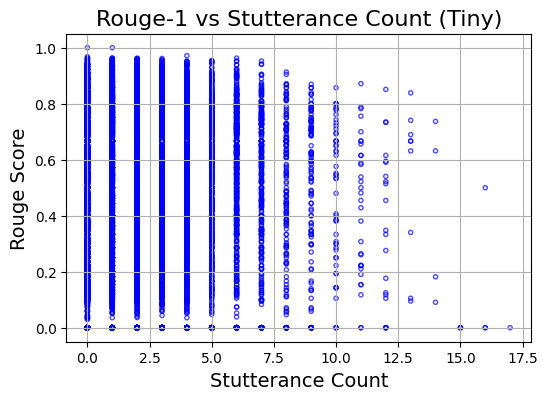

In [129]:
plt.figure(figsize=(6, 4))
# plt.scatter(
#     net_aigenerated_data_whisper_tiny["Stuttering_Count"], 
#     net_aigenerated_data_whisper_tiny["rouge1-precision"], 
#     facecolors="none", edgecolors='r',
#     marker="8",
#     alpha=0.7  # Handle overlapping points
# )

# plt.scatter(
#     net_aigenerated_data_whisper_tiny["Stuttering_Count"], 
#     net_aigenerated_data_whisper_tiny["rouge1-recall"], 
#     facecolors="none", edgecolors='g',
#     marker="^",
#     alpha=0.7  # Handle overlapping points
# )

plt.scatter(
    net_aigenerated_data_whisper_tiny["Stuttering_Count"], 
    net_aigenerated_data_whisper_tiny["stu-rouge1-f1"], 
    facecolors="none", edgecolors='b',
    marker=".",
    alpha=0.7  # Handle overlapping points
)

plt.title("Rouge-1 vs Stutterance Count (Tiny)", fontsize=16)
plt.xlabel("Stutterance Count", fontsize=14)
plt.ylabel("Rouge Score", fontsize=14)
plt.grid(True)
plt.show()

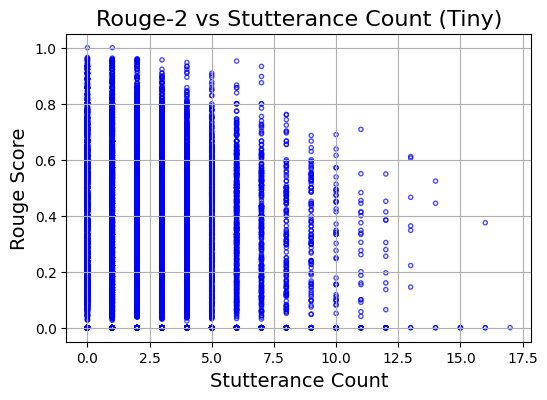

In [130]:
plt.figure(figsize=(6, 4))
# plt.scatter(
#     net_aigenerated_data_whisper_tiny["Stuttering_Count"], 
#     net_aigenerated_data_whisper_tiny["rouge2-precision"], 
#     facecolors="none", edgecolors='r',
#     marker="8",
#     alpha=0.7  # Handle overlapping points
# )

# plt.scatter(
#     net_aigenerated_data_whisper_tiny["Stuttering_Count"], 
#     net_aigenerated_data_whisper_tiny["rouge2-recall"], 
#     facecolors="none", edgecolors='g',
#     marker="^",
#     alpha=0.7  # Handle overlapping points
# )

plt.scatter(
    net_aigenerated_data_whisper_tiny["Stuttering_Count"], 
    net_aigenerated_data_whisper_tiny["stu-rouge2-f1"], 
    facecolors="none", edgecolors='b',
    marker=".",
    alpha=0.7  # Handle overlapping points
)

plt.title("Rouge-2 vs Stutterance Count (Tiny)", fontsize=16)
plt.xlabel("Stutterance Count", fontsize=14)
plt.ylabel("Rouge Score", fontsize=14)
plt.grid(True)
plt.show()

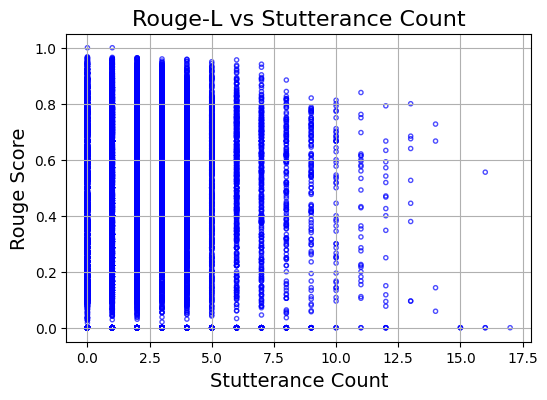

In [131]:
plt.figure(figsize=(6, 4))
# plt.scatter(
#     net_aigenerated_data_whisper_tiny["Stuttering_Count"], 
#     net_aigenerated_data_whisper_tiny["rougel-precision"], 
#     facecolors="none", edgecolors='r',
#     marker="8",
#     alpha=0.7  # Handle overlapping points
# )

# plt.scatter(
#     net_aigenerated_data_whisper_tiny["Stuttering_Count"], 
#     net_aigenerated_data_whisper_tiny["rougel-recall"], 
#     facecolors="none", edgecolors='g',
#     marker="^",
#     alpha=0.7  # Handle overlapping points
# )

plt.scatter(
    net_aigenerated_data_whisper_tiny["Stuttering_Count"], 
    net_aigenerated_data_whisper_tiny["stu-rougel-f1"], 
    facecolors="none", edgecolors='b',
    marker=".",
    alpha=0.7  # Handle overlapping points
)

plt.title("Rouge-L vs Stutterance Count", fontsize=16)
plt.xlabel("Stutterance Count", fontsize=14)
plt.ylabel("Rouge Score", fontsize=14)
plt.grid(True)
plt.show()

## Correlations between Stuttering and Rouge Scores (Whisper Large)

In [132]:
from scipy.stats import spearmanr

rho, p = spearmanr(net_aigenerated_data_whisper_tiny.dropna()['Stuttering_Count'], net_aigenerated_data_whisper_tiny.dropna()['stu-rouge1-f1'])
print(f"p-value [stuttering count & rouge-1 f1] = {p}")
print(f"rho [stuttering count & rouge-1 f1] = {rho}")


rho, p = spearmanr(net_aigenerated_data_whisper_tiny.dropna()['Stuttering_Count'], net_aigenerated_data_whisper_tiny.dropna()['stu-rouge2-f1'])
print(f"p-value [stuttering count & rouge-1 f1] = {p}")
print(f"rho [stuttering count & rouge-1 f1] = {rho}")


rho, p = spearmanr(net_aigenerated_data_whisper_tiny.dropna()['Stuttering_Count'], net_aigenerated_data_whisper_tiny.dropna()['stu-rougel-f1'])
print(f"p-value [stuttering count & rouge-1 f1] = {p}")
print(f"rho [stuttering count & rouge-1 f1] = {rho}")

p-value [stuttering count & rouge-1 f1] = 0.0
rho [stuttering count & rouge-1 f1] = 0.3803532009602399
p-value [stuttering count & rouge-1 f1] = 0.0
rho [stuttering count & rouge-1 f1] = 0.4165913363643142
p-value [stuttering count & rouge-1 f1] = 0.0
rho [stuttering count & rouge-1 f1] = 0.37240026947567445
